Fichier RDF chargé avec succès avec 510 triples.
Conversion du graphe en non dirigé pour l'algorithme de Louvain.
Partition Louvain terminée.


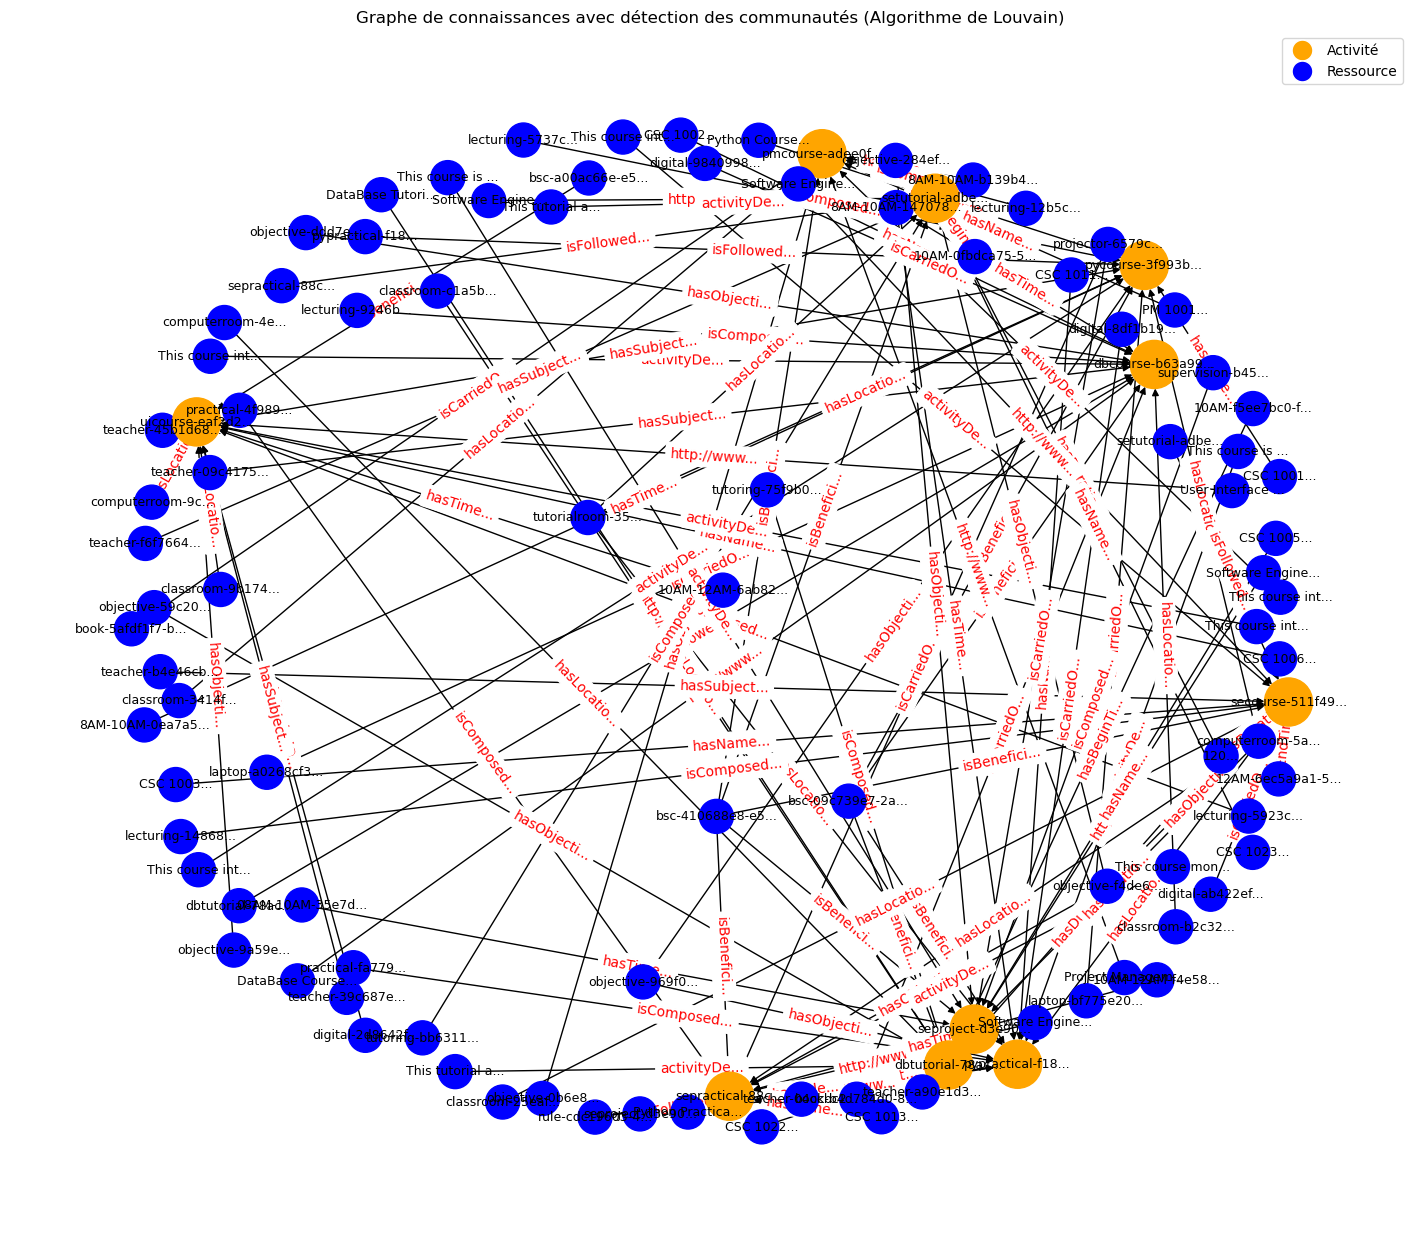

Visualisation de la communauté 1 avec 12 nœuds


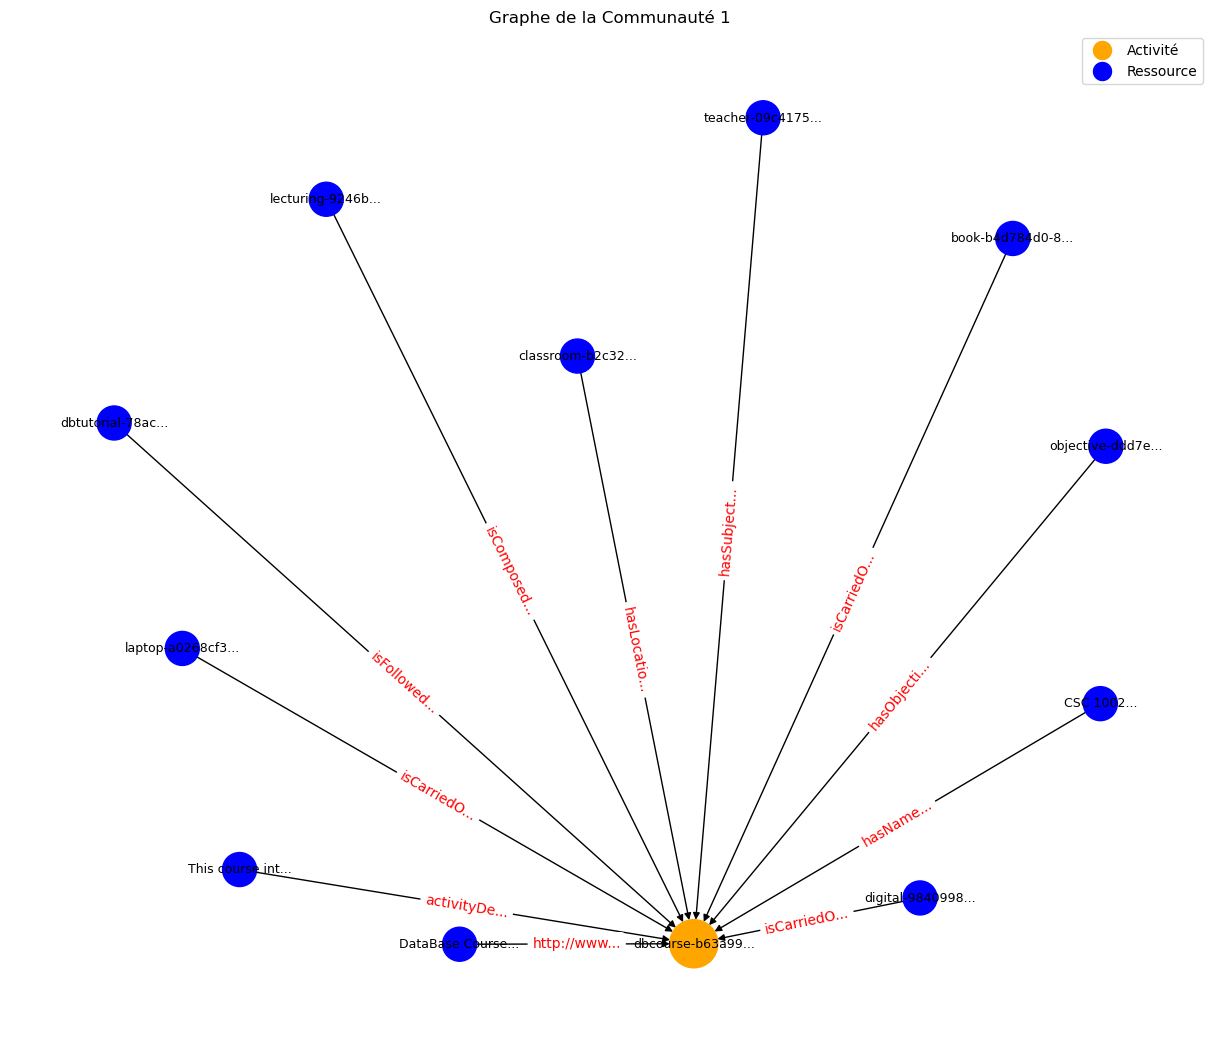

Visualisation de la communauté 2 avec 8 nœuds


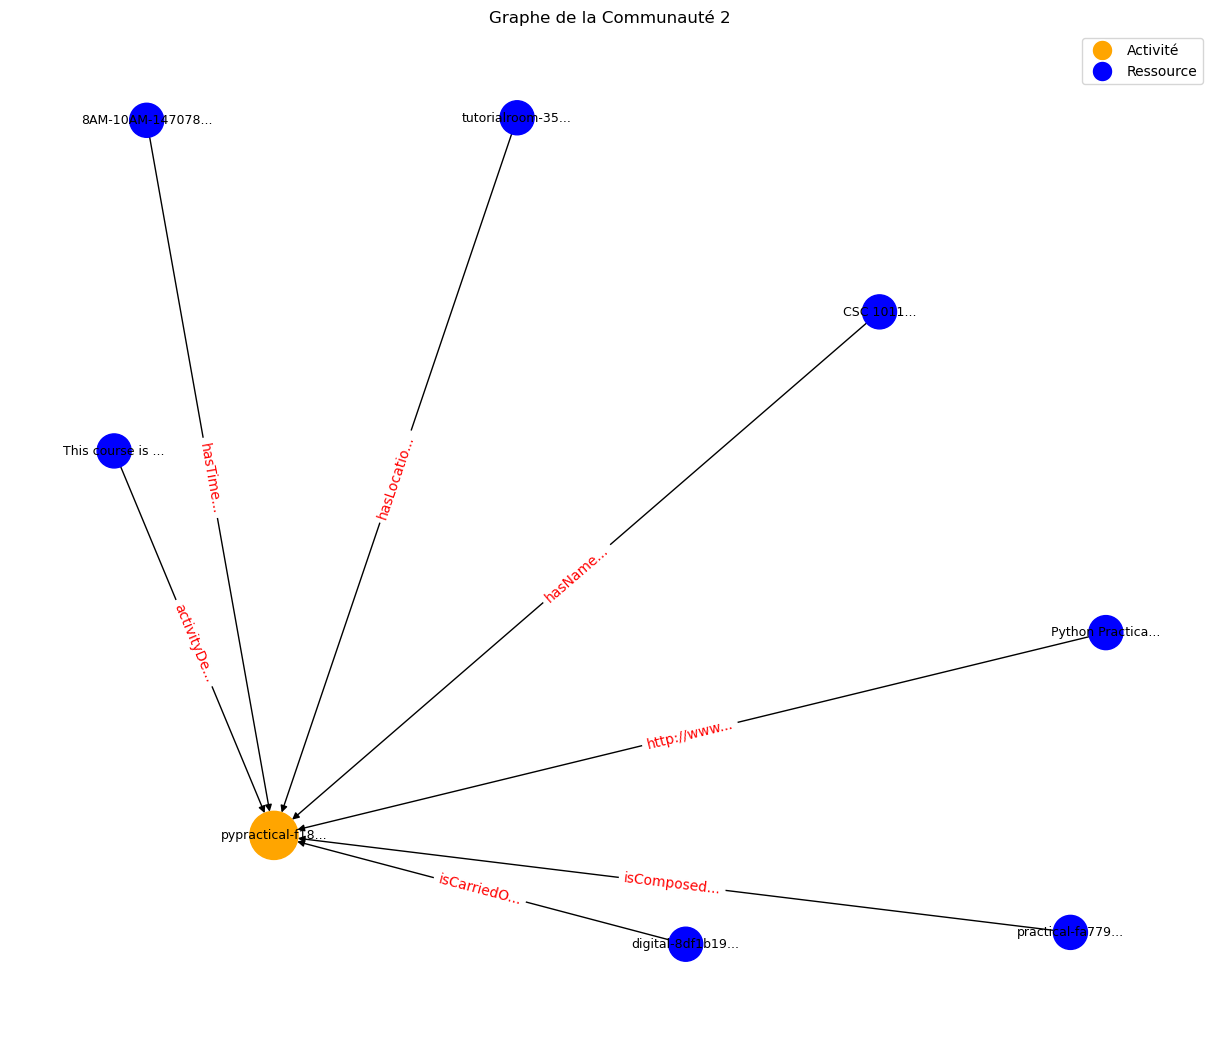

Visualisation de la communauté 5 avec 11 nœuds


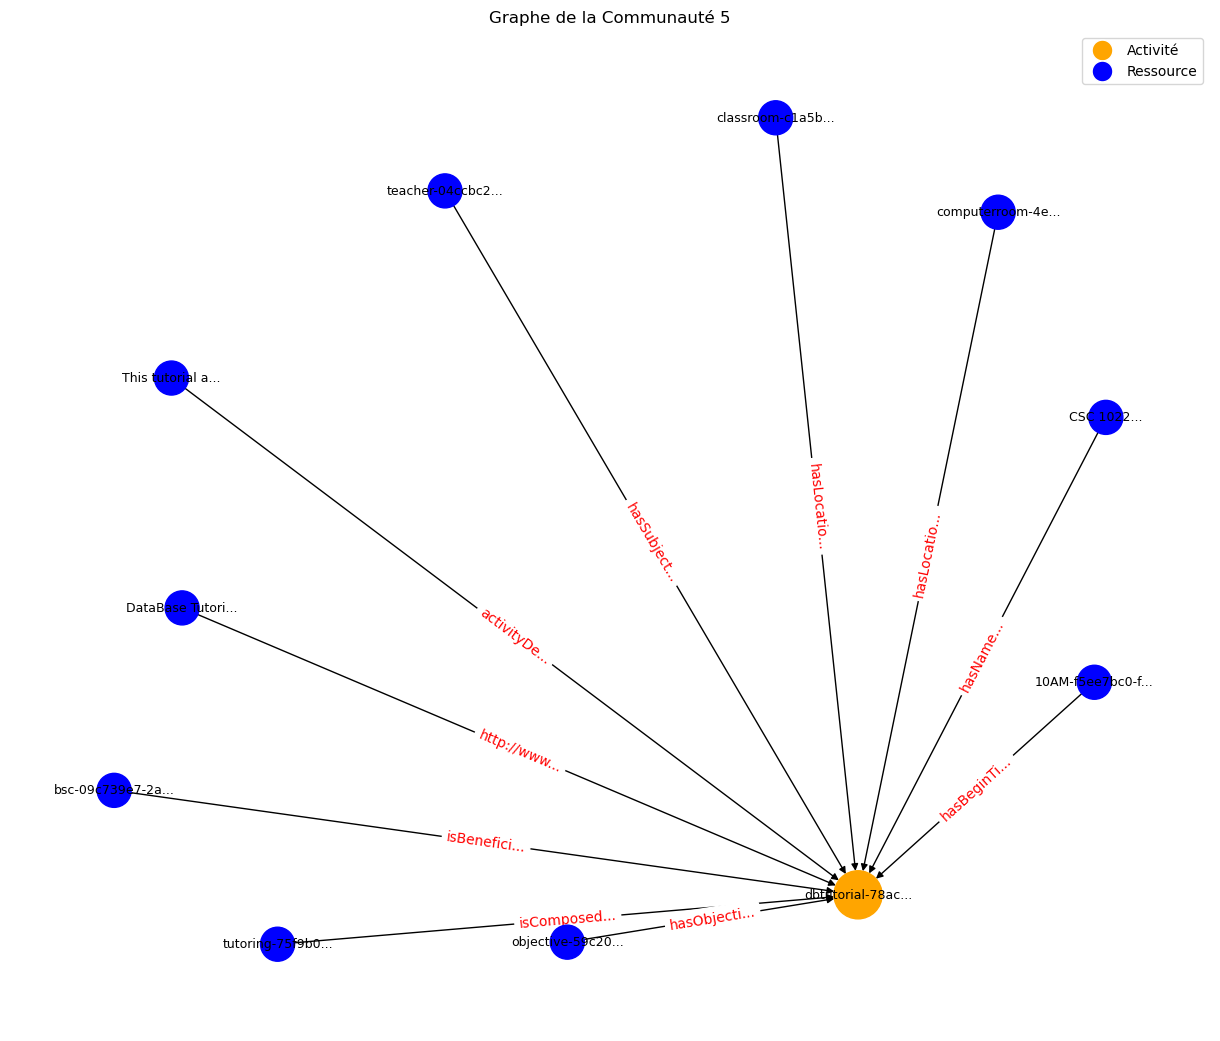

Visualisation de la communauté 4 avec 9 nœuds


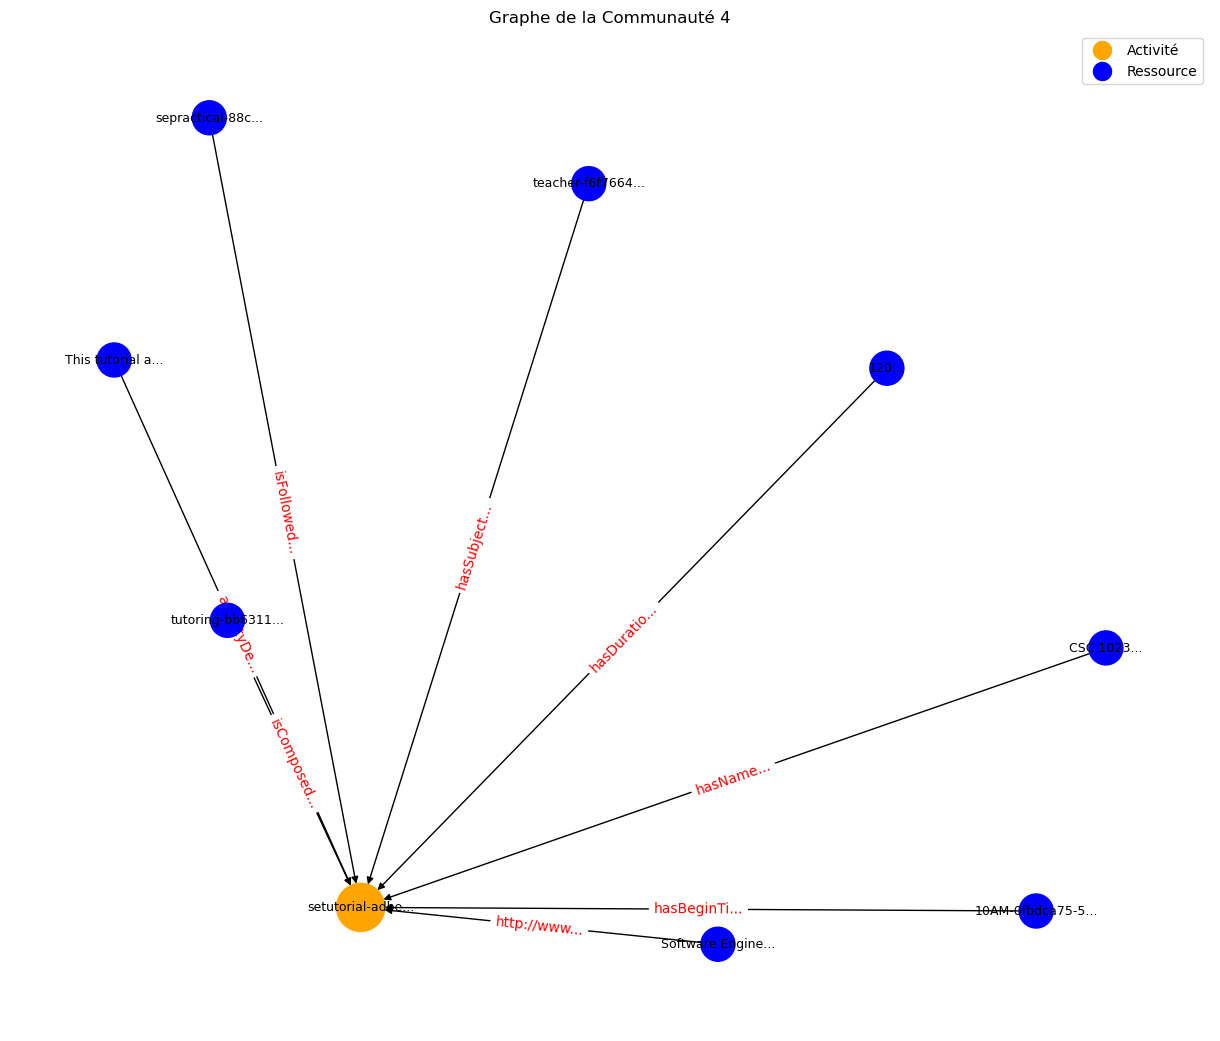

Visualisation de la communauté 8 avec 10 nœuds


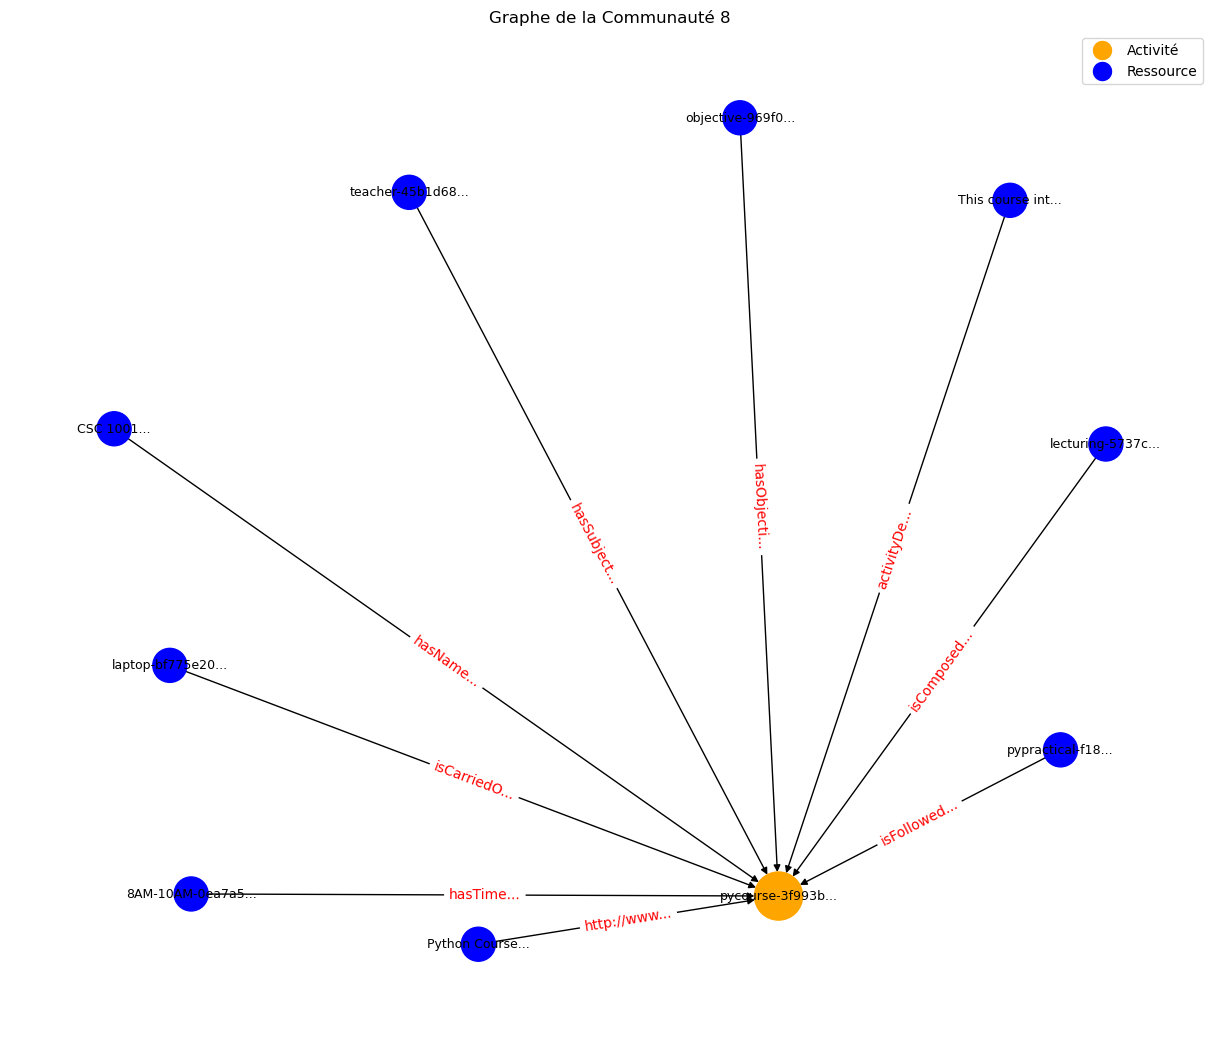

Visualisation de la communauté 9 avec 10 nœuds


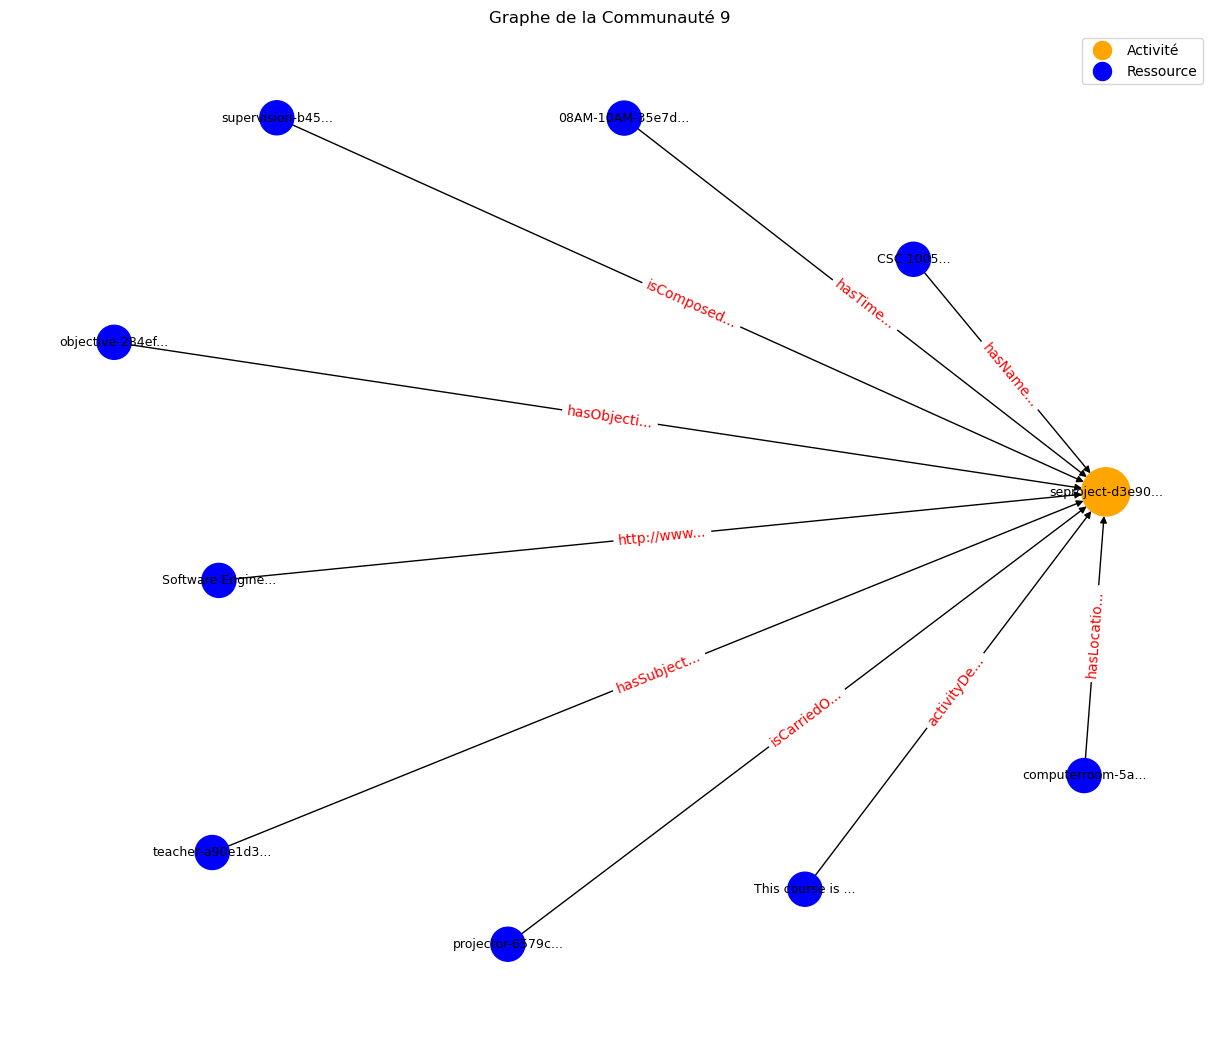

Visualisation de la communauté 6 avec 9 nœuds


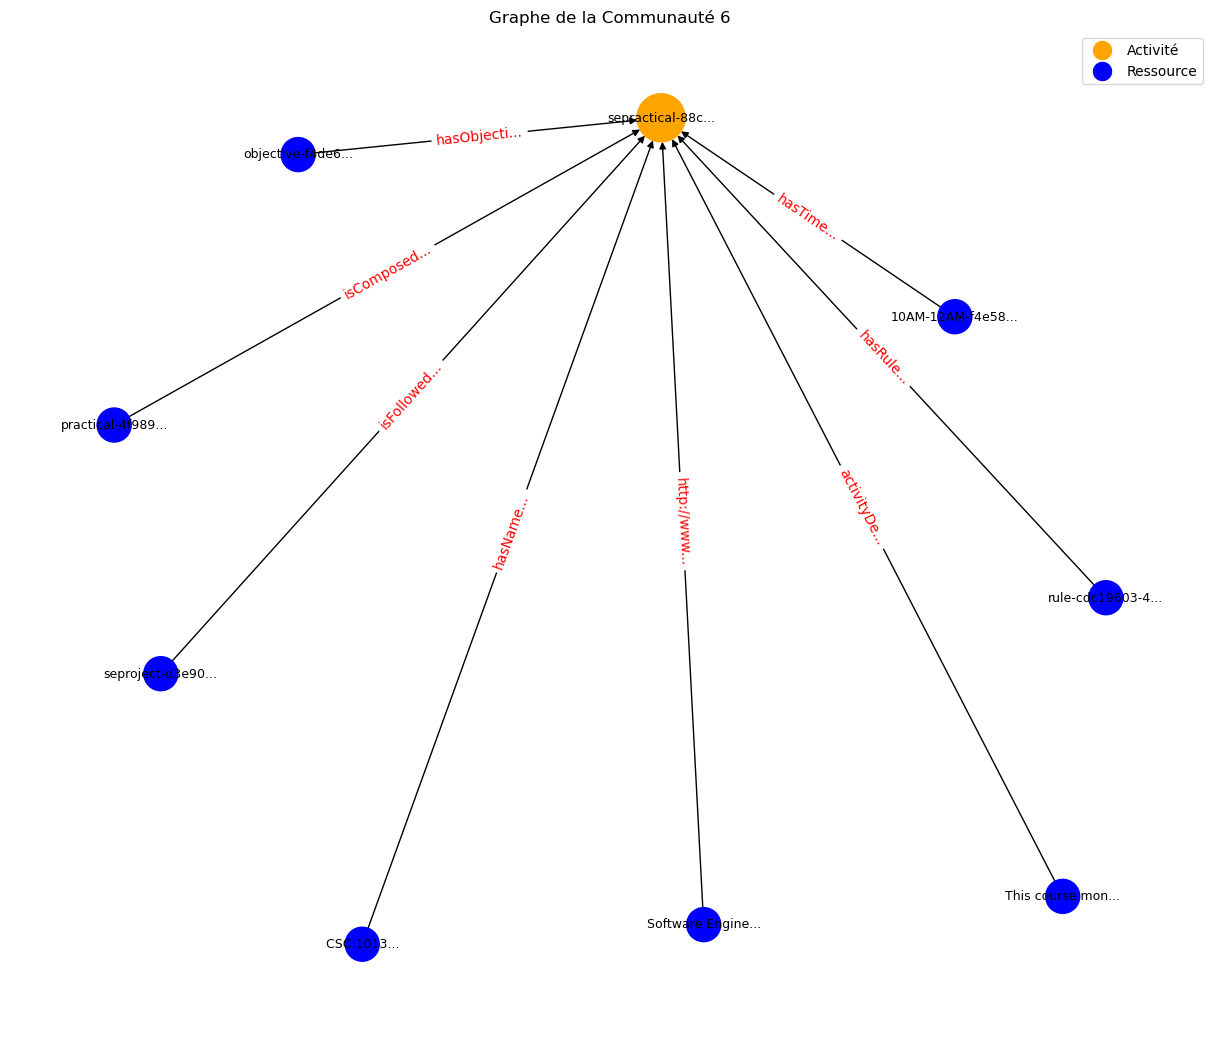

Visualisation de la communauté 3 avec 12 nœuds


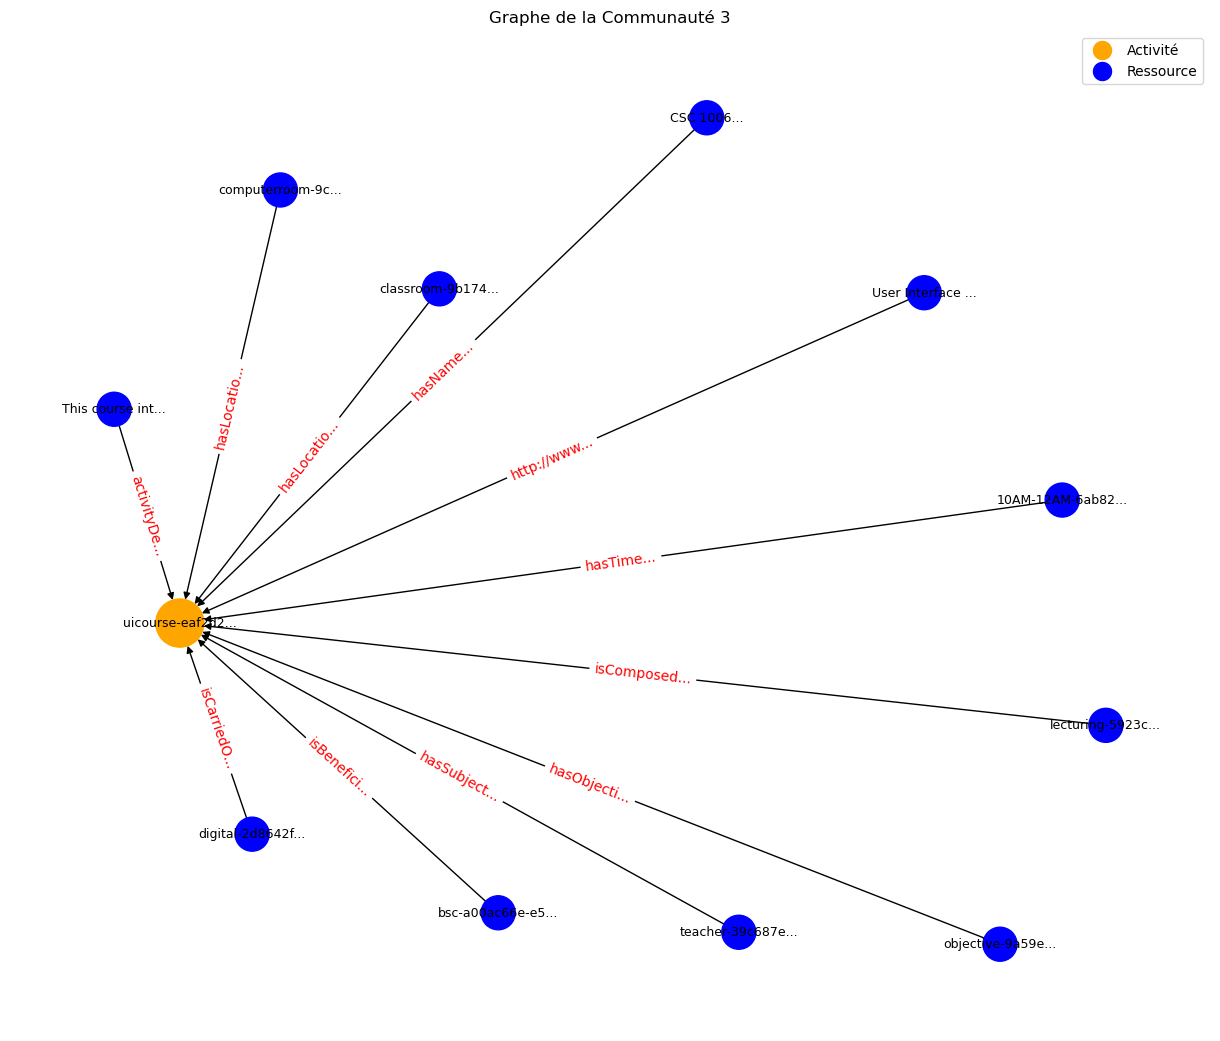

Visualisation de la communauté 7 avec 10 nœuds


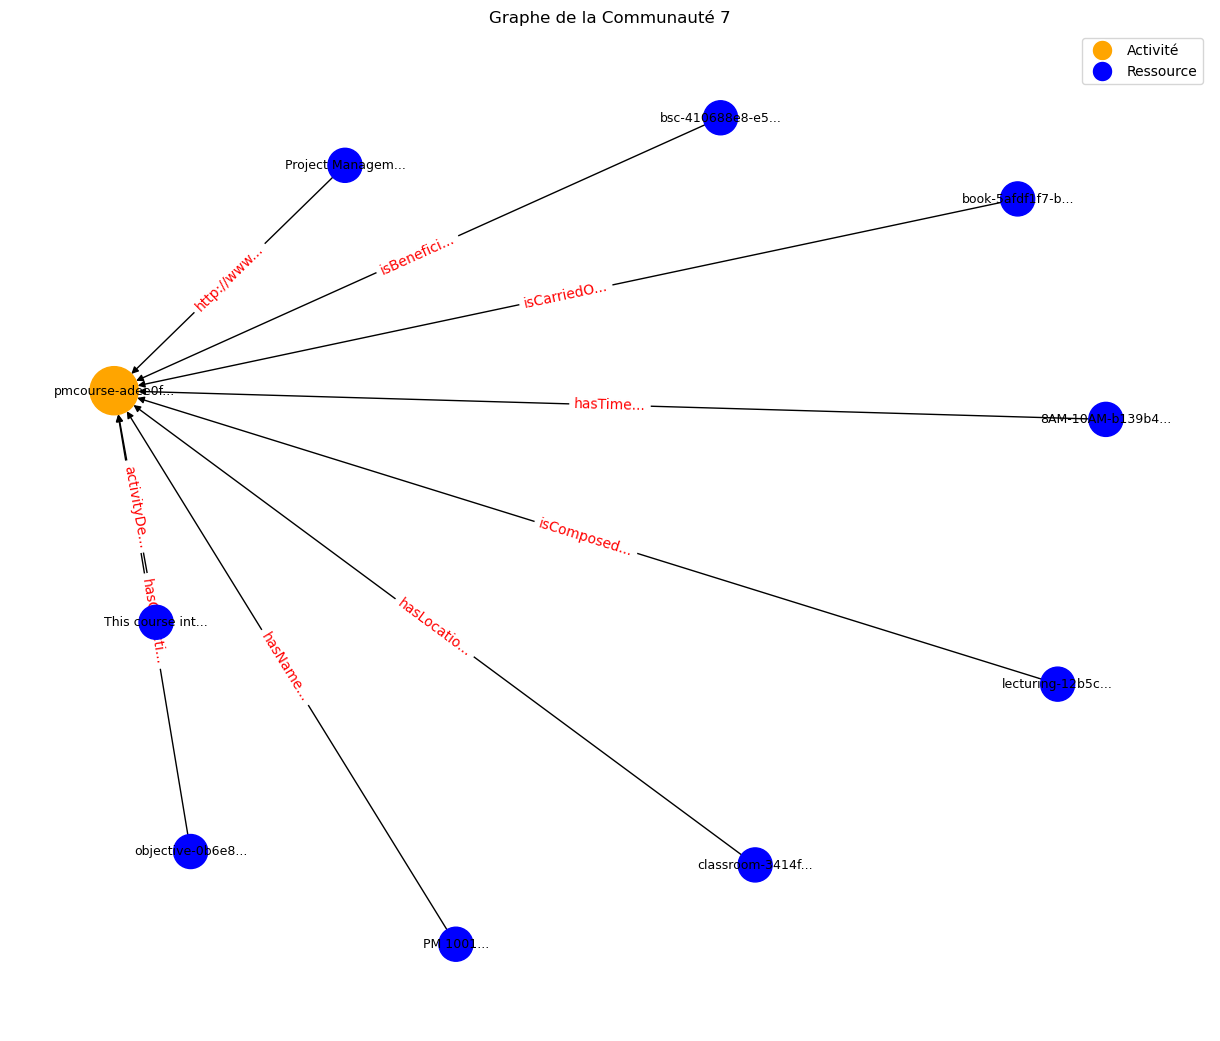

Visualisation de la communauté 0 avec 10 nœuds


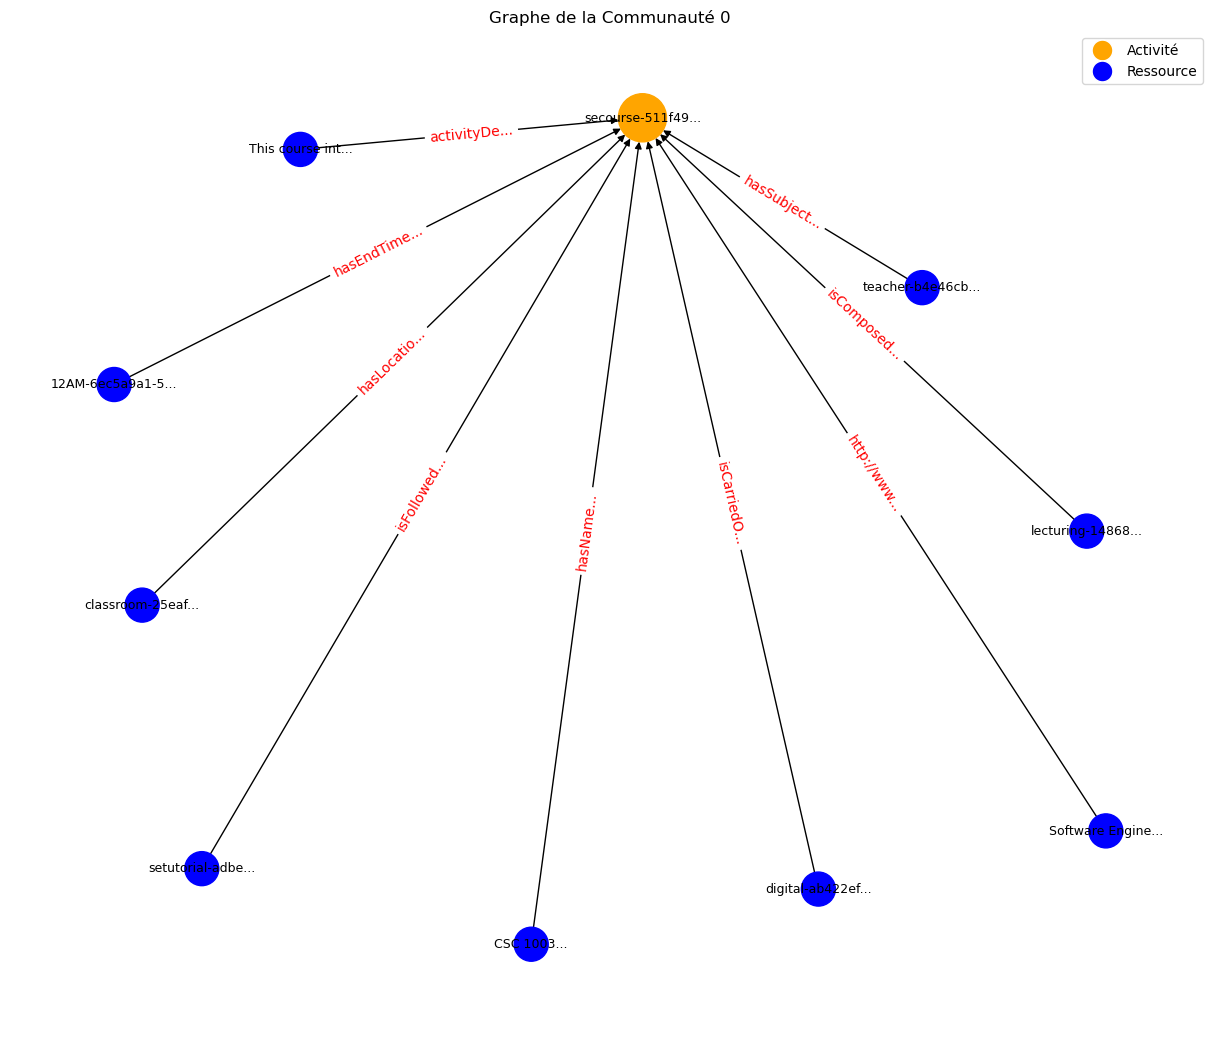

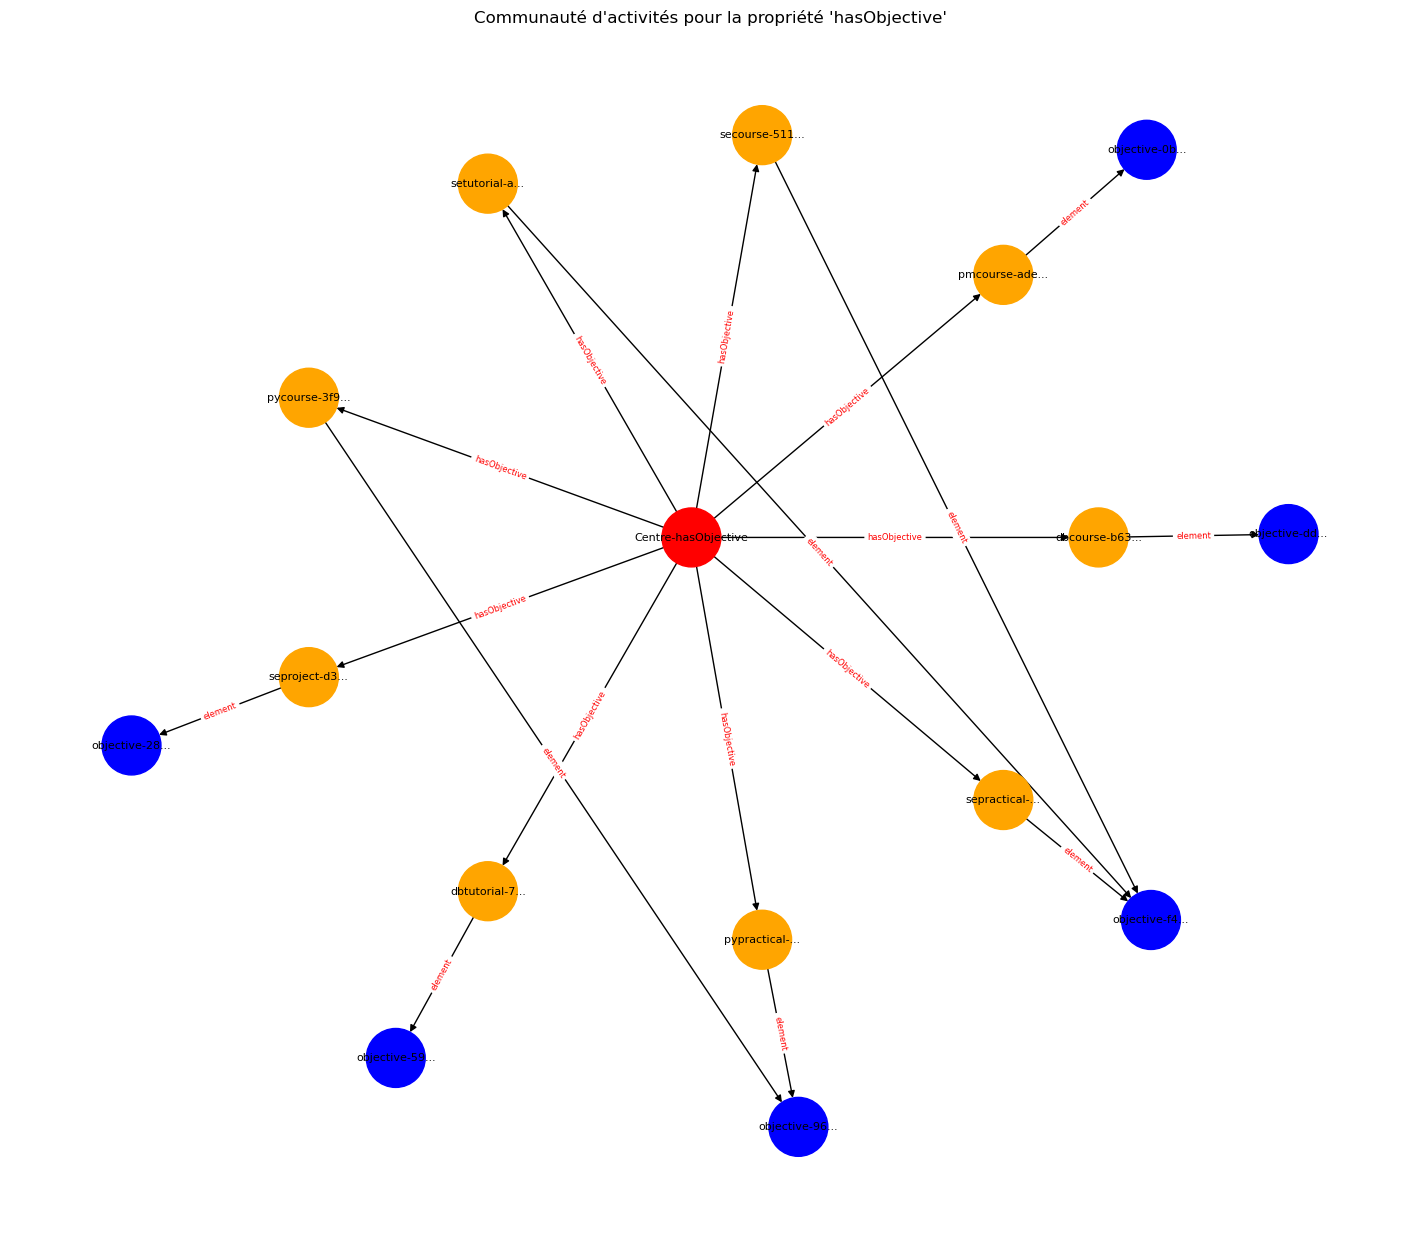

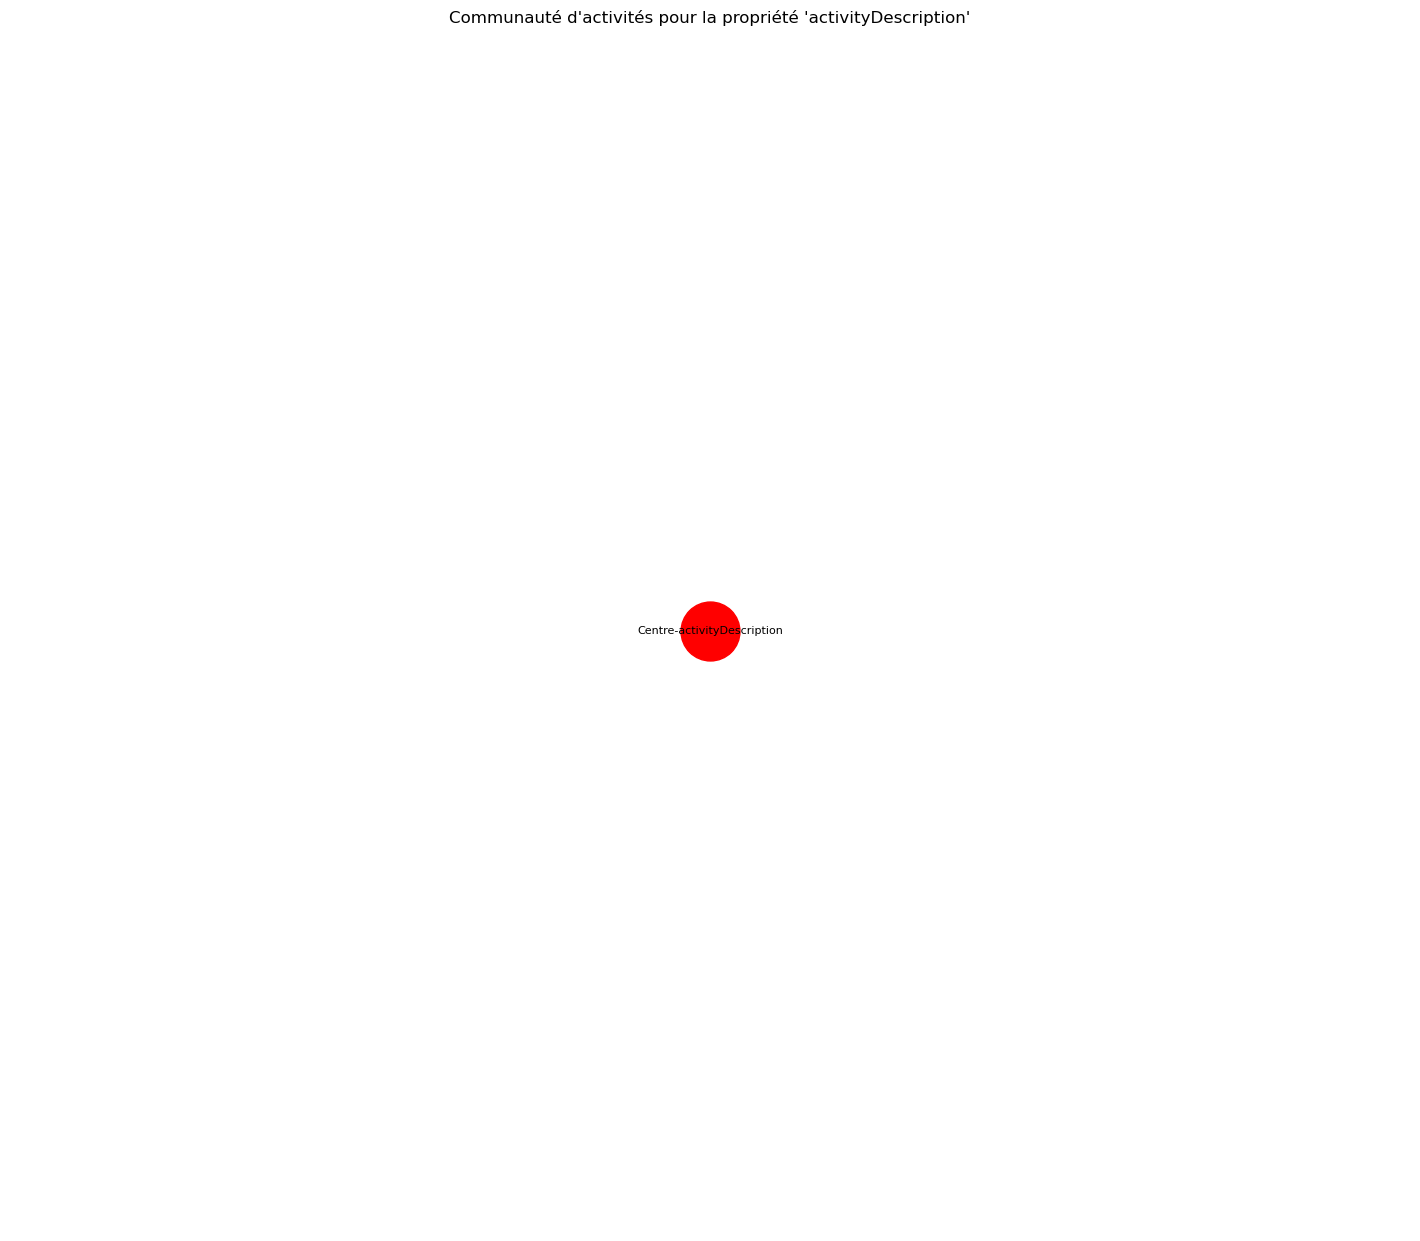

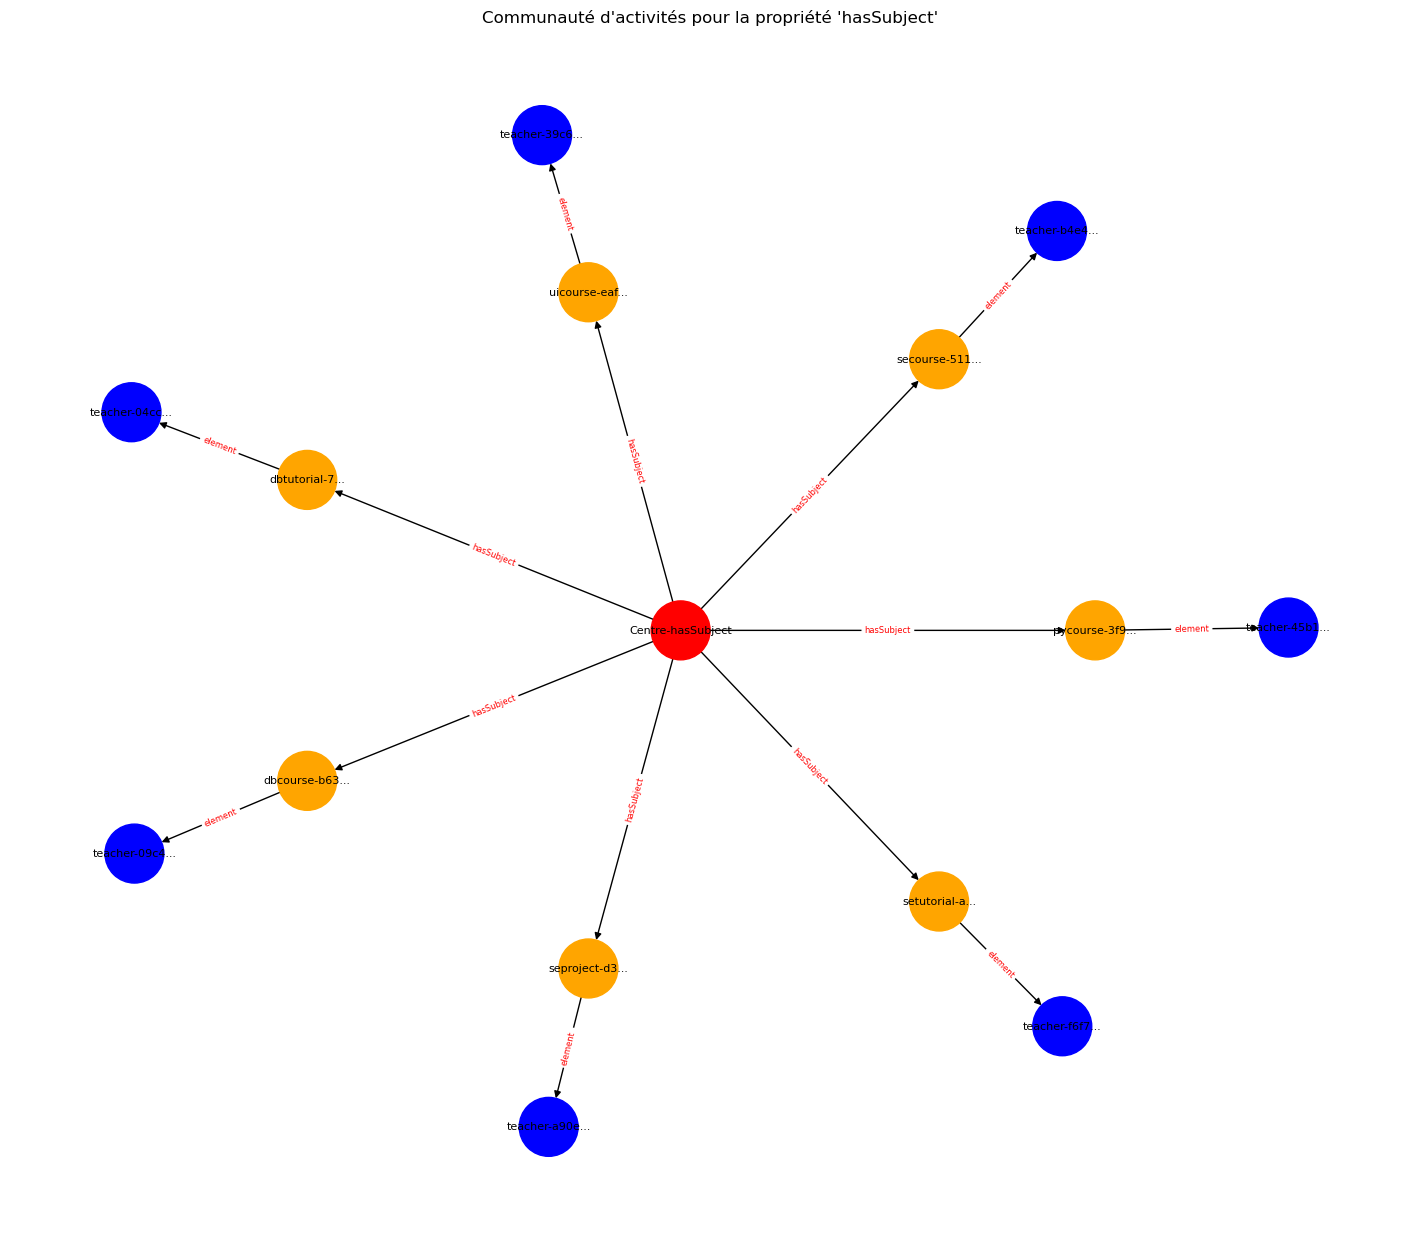

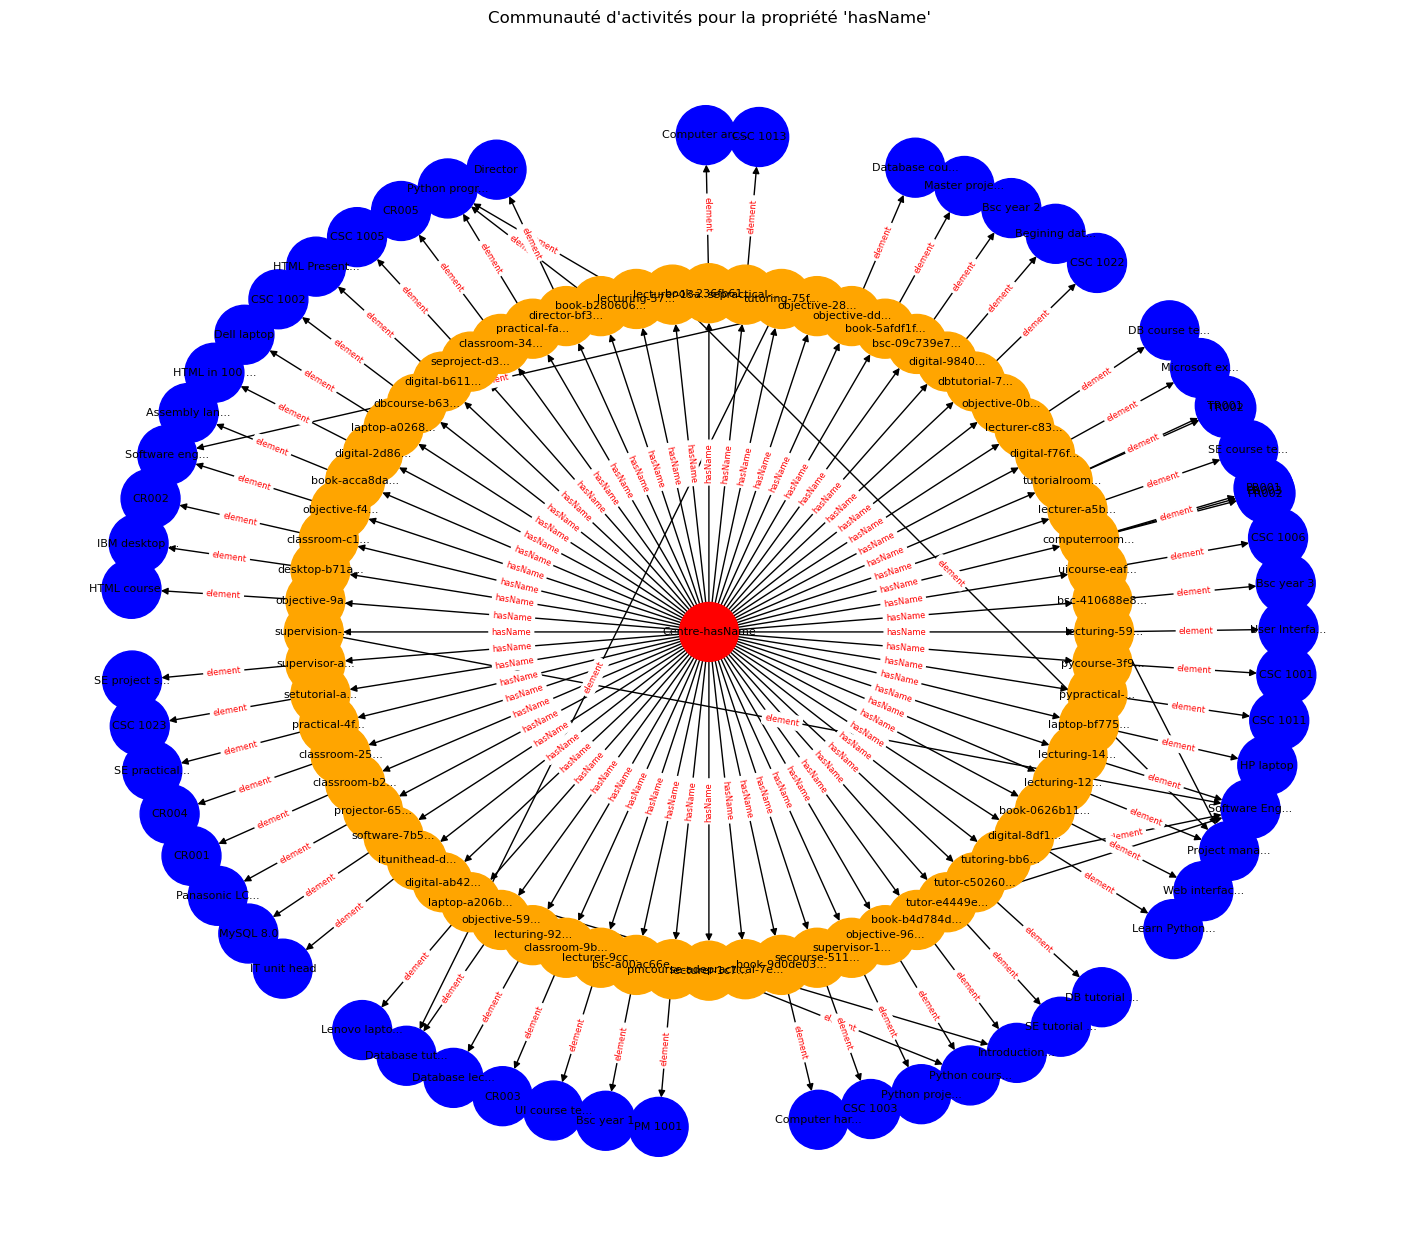

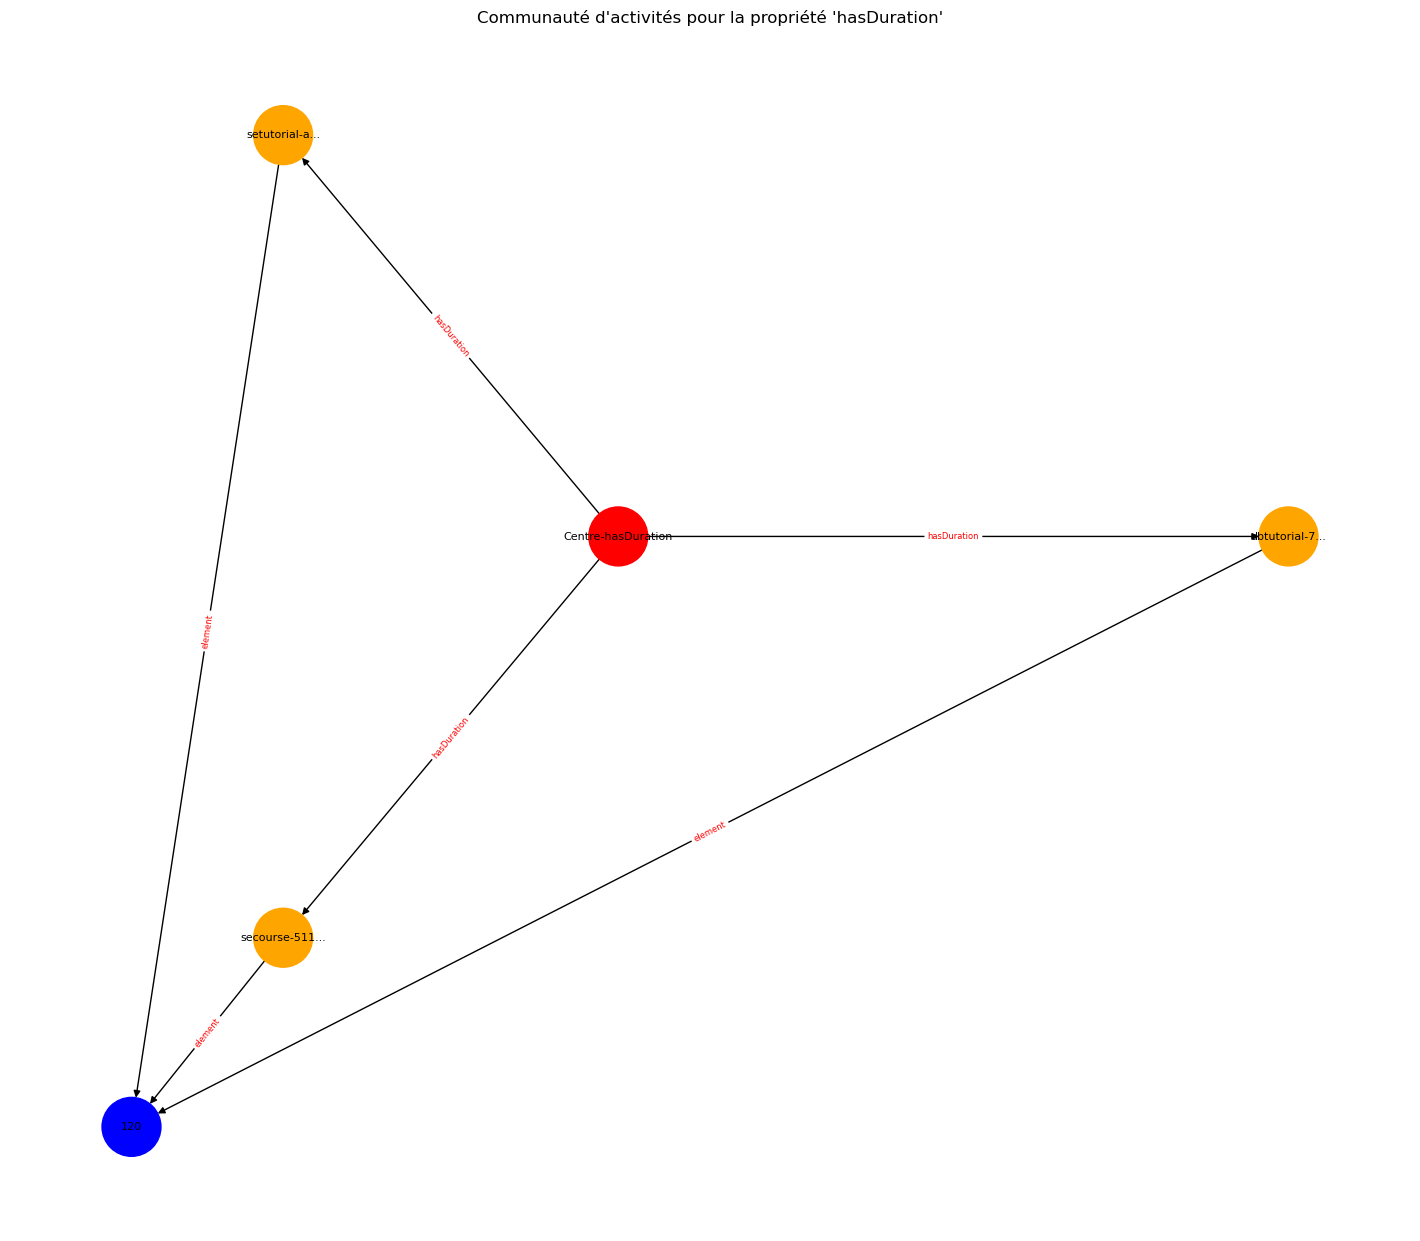

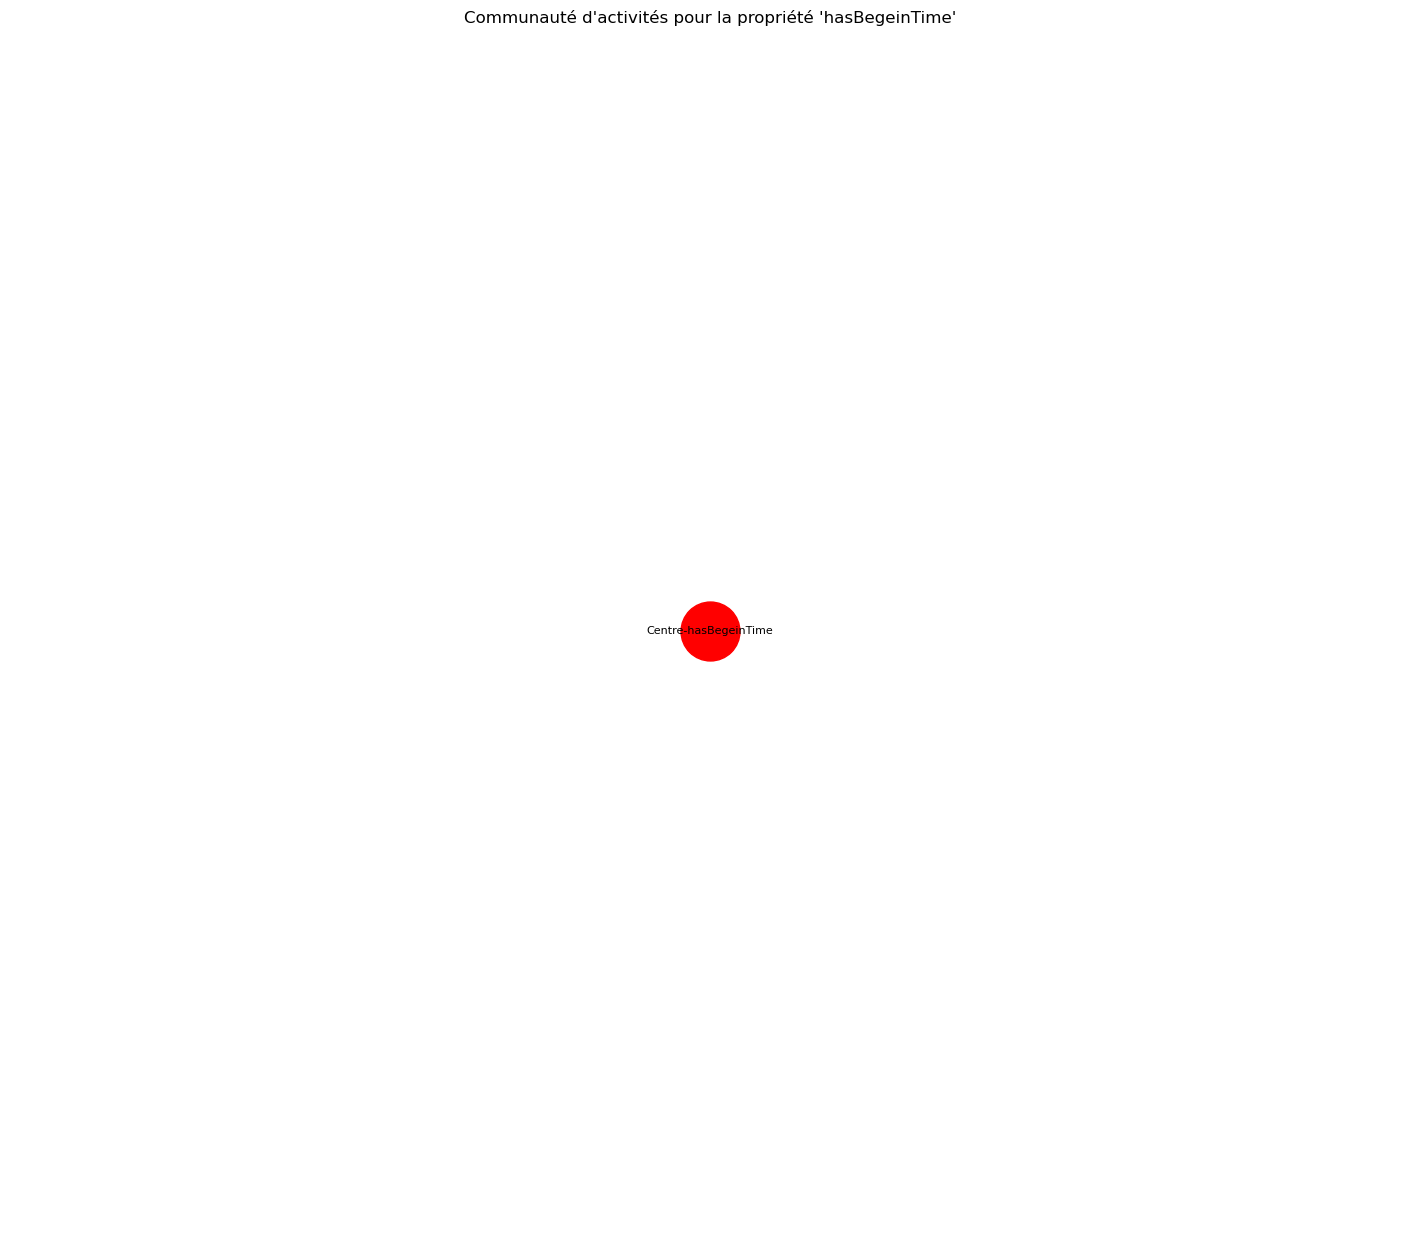

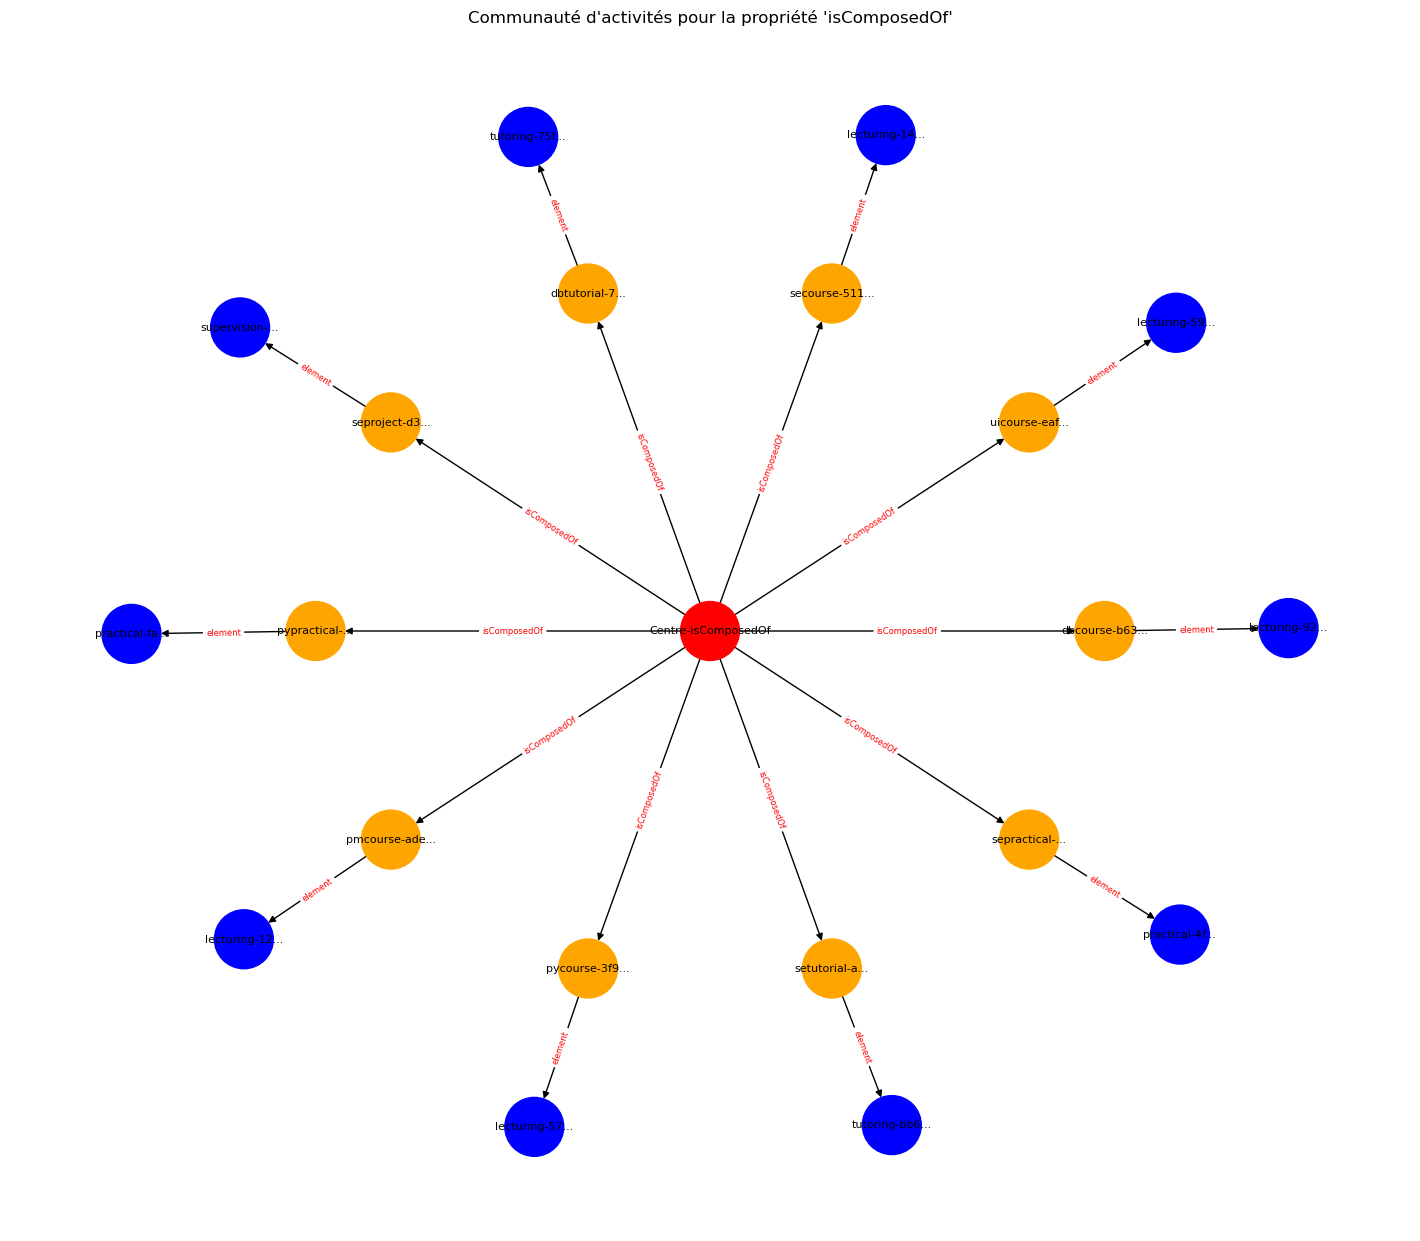

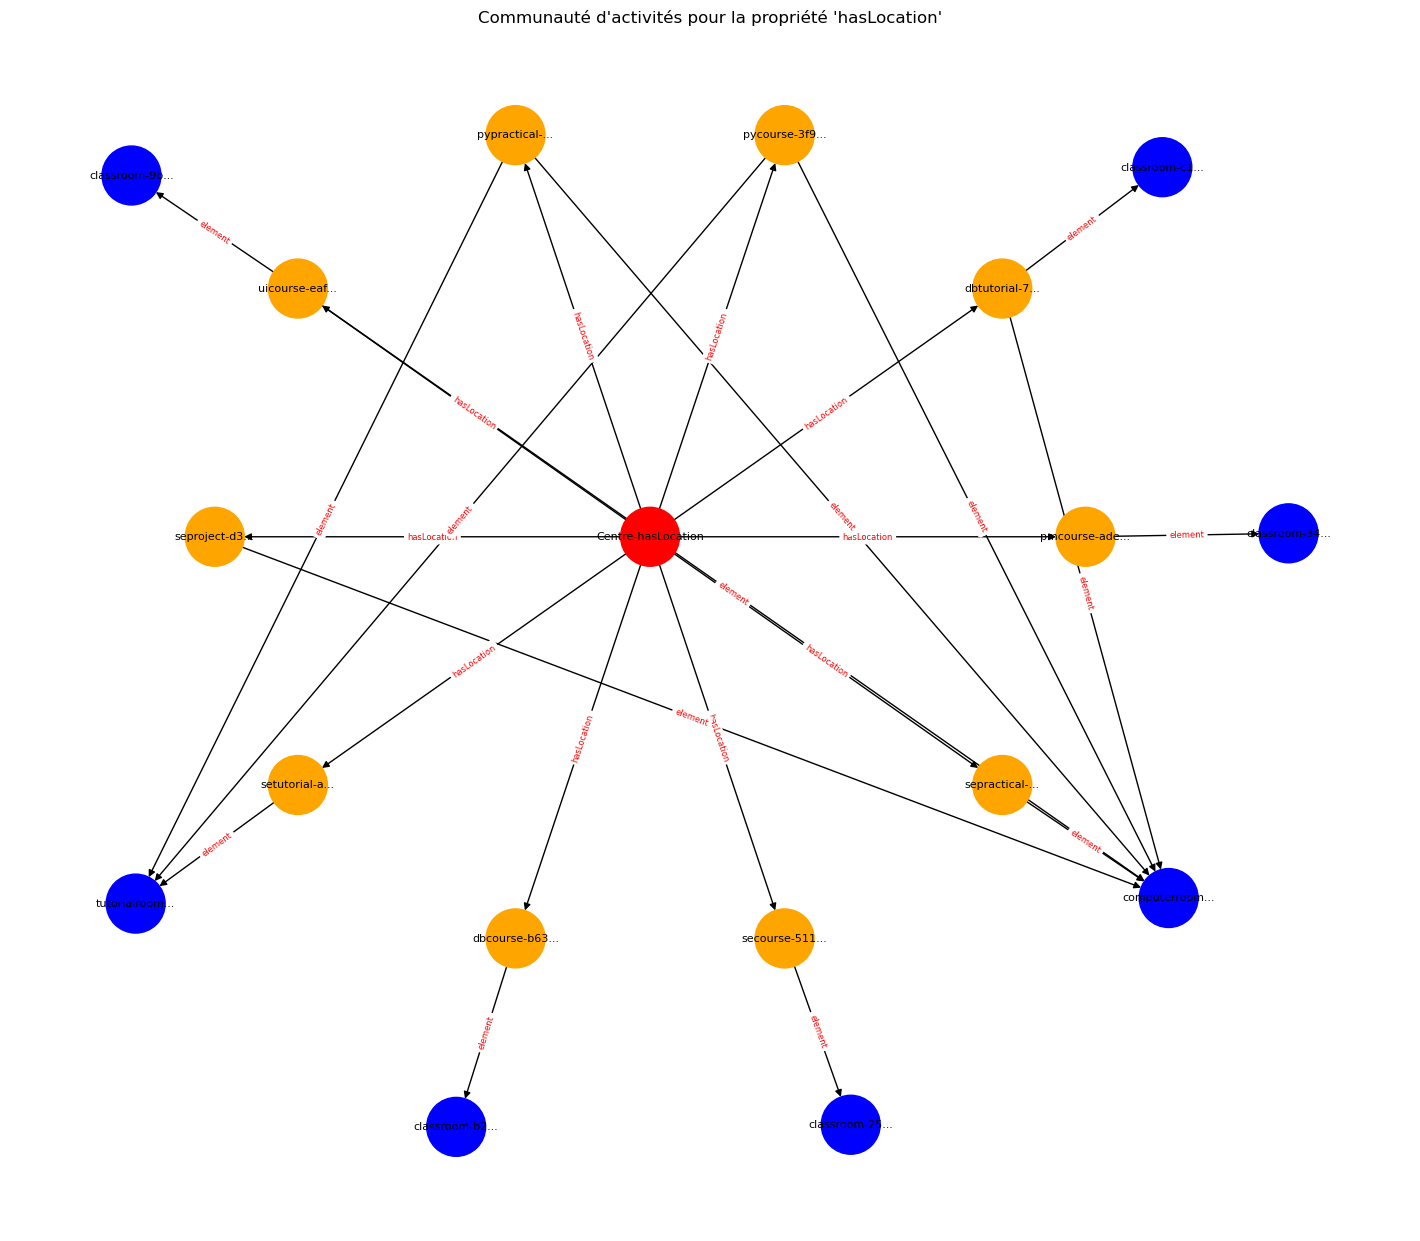

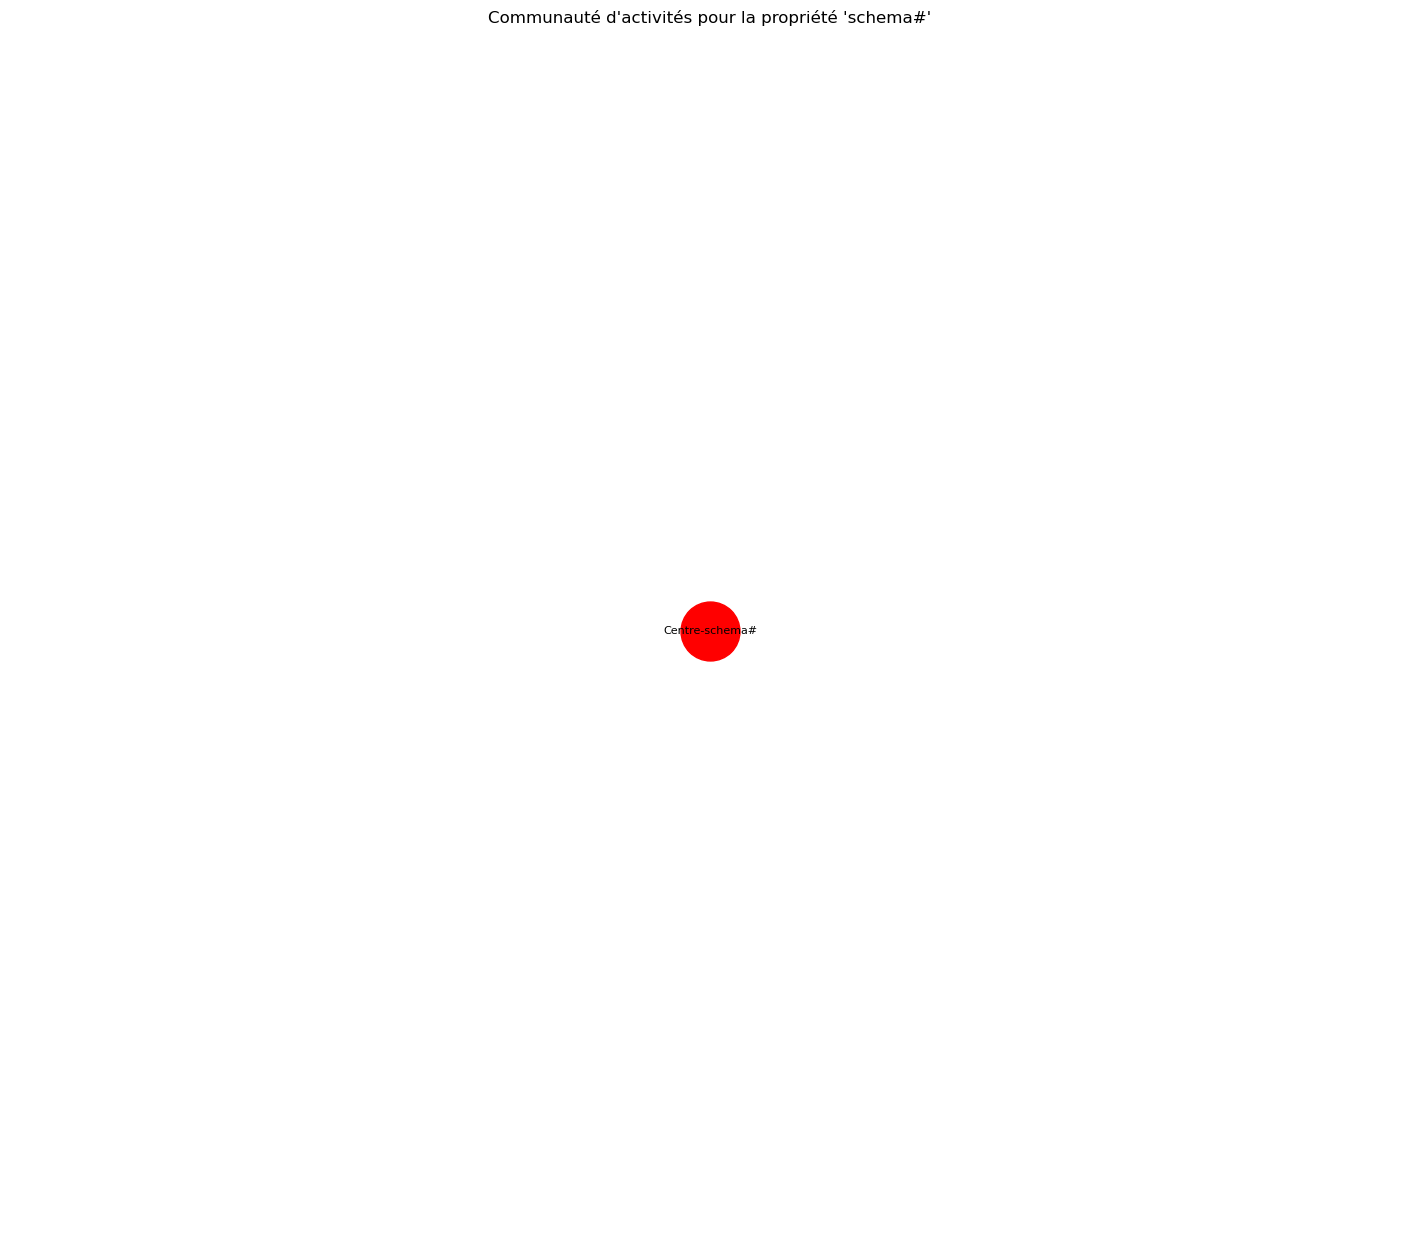

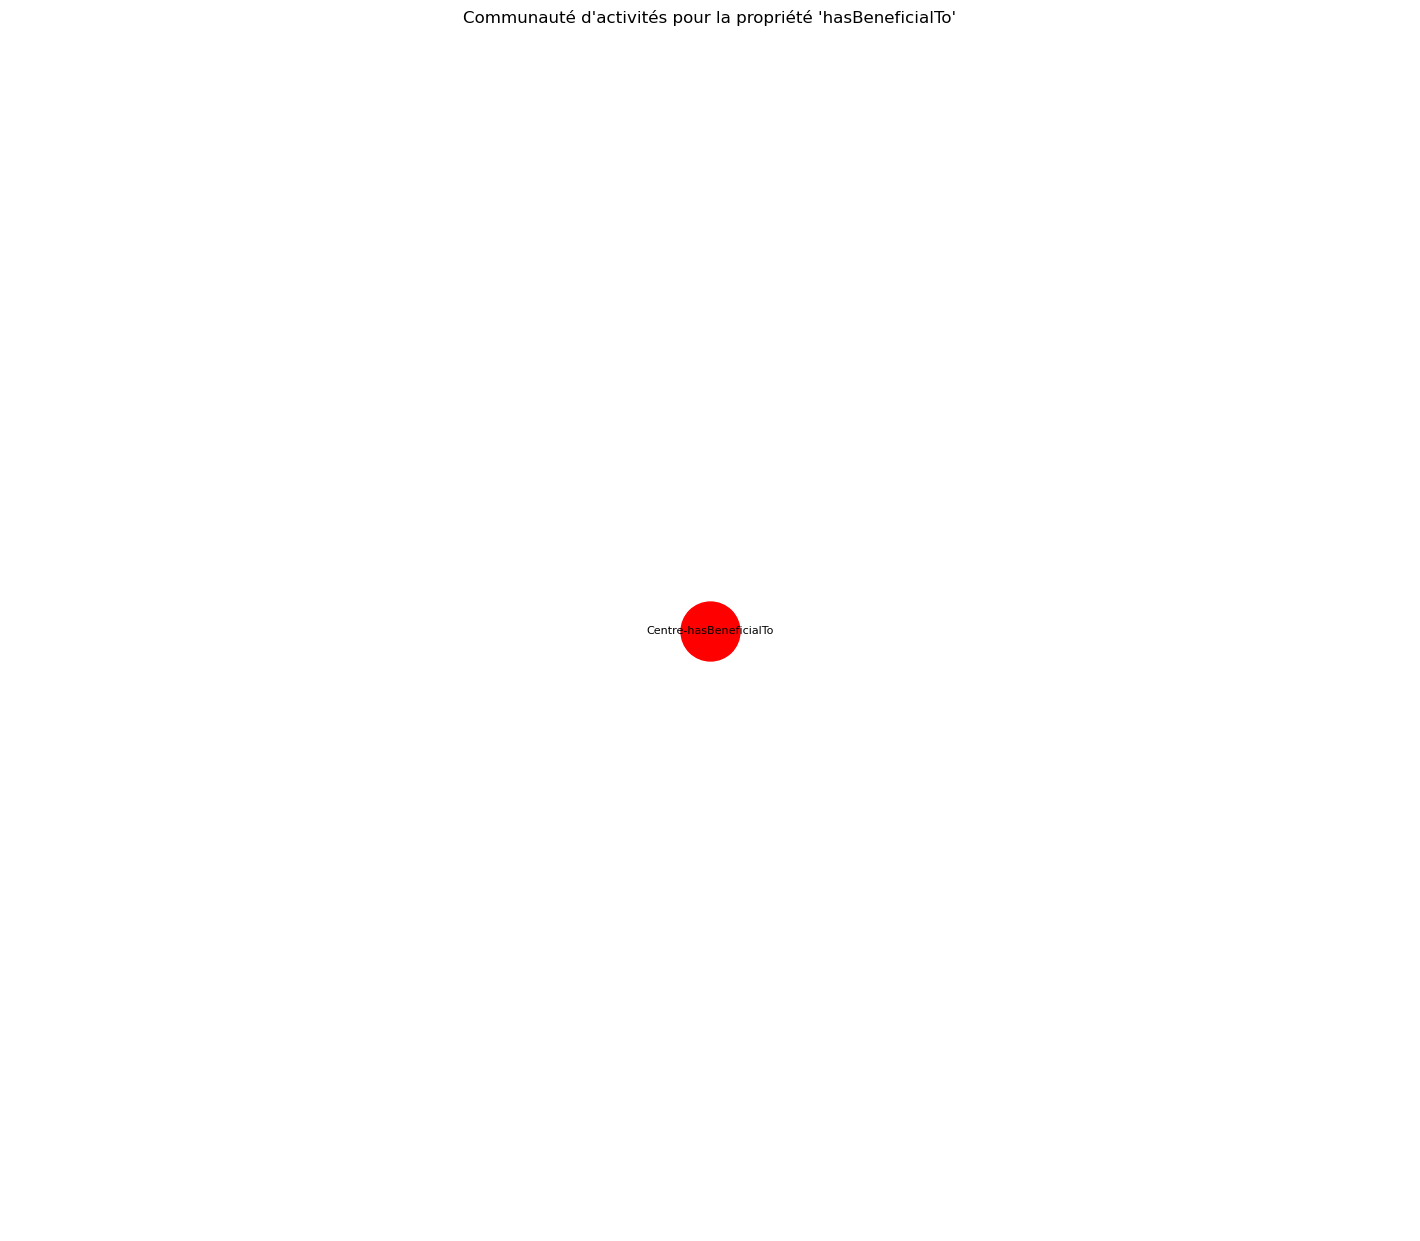

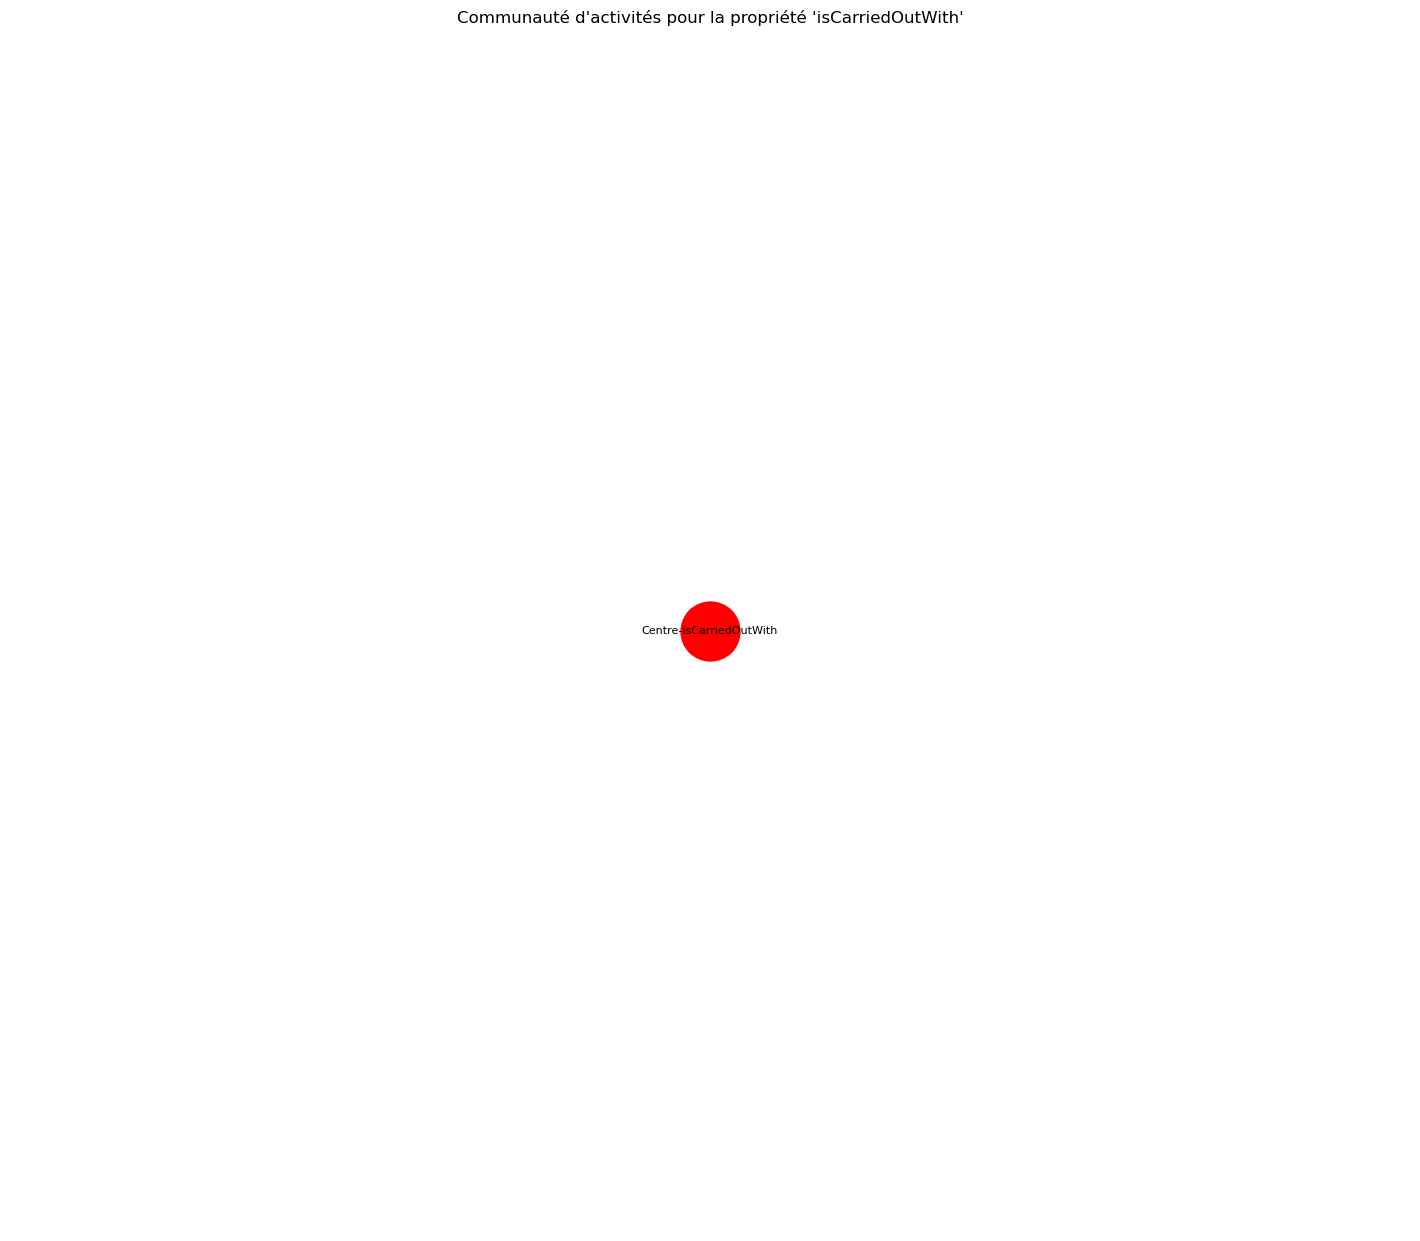

Fichier RDF chargé avec succès avec 510 triples.
Partition Louvain terminée.


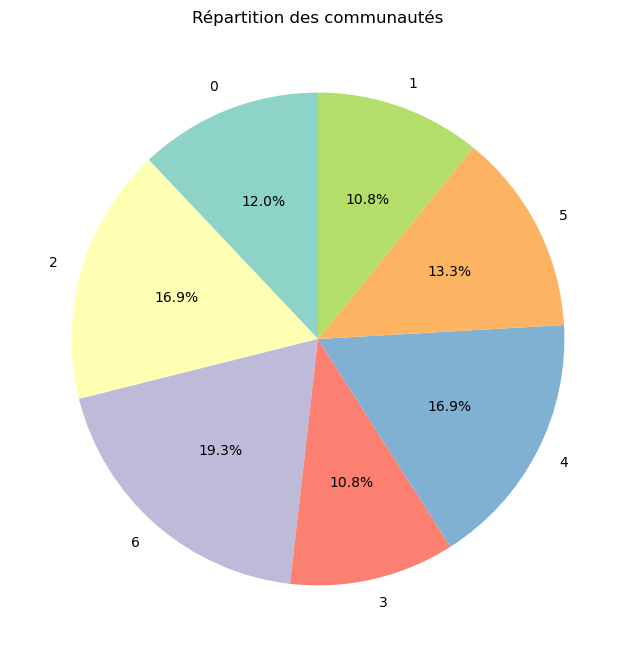

Partition Louvain terminée.


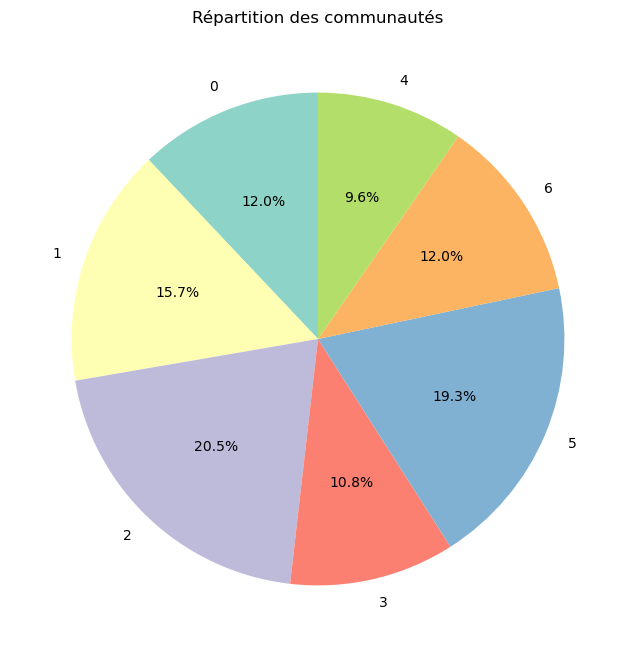

Conductance de la communauté 0 : 0.2174
Conductance de la communauté 1 : 0.3617
Conductance de la communauté 2 : 0.1915
Conductance de la communauté 3 : 0.2727
Conductance de la communauté 4 : 0.1250
Conductance de la communauté 5 : 0.2245
Conductance de la communauté 6 : 0.1000
Le niveau optimal est 1 avec une modularité de 0.5975765306122449


In [53]:
!pip install rdflib networkx scikit-learn matplotlib
!pip install rdflib networkx scikit-learn matplotlib
!pip install rdflib
!pip install networkx
!pip install scikit-learn
!pip install matplotlib
!pip install python-louvain
!pip install graphistry



from rdflib import URIRef, BNode, Literal
from rdflib import Namespace
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL
from rdflib import Graph, URIRef, Literal, BNode
from rdflib.namespace import FOAF, RDF
from rdflib import URIRef, BNode, Literal
from rdflib import Namespace
from rdflib.namespace import CSVW, DC, DCAT, DCTERMS, DOAP, FOAF, ODRL2, ORG, OWL
from rdflib import Graph, URIRef, Literal, BNode
from rdflib.namespace import FOAF, RDF
from rdflib import Graph, RDF, URIRef, Namespace
from rdflib import Namespace, Graph, URIRef
from rdflib.namespace import RDF
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
import community.community_louvain as community_louvain
import re
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter


# Définir les namespaces
akg_namespace = Namespace("http://sonfack.com/2023/12/tao/")
cao_namespace = Namespace("http://sonfack.com/2023/12/cao/")

# Chemin du fichier RDF
akg_file = "teaching_akg.ttl"  # Assurez-vous que le fichier existe à cet emplacement

# Charger le fichier RDF
def load_graph(file_path):
    g = Graph()
    g.parse(file_path)
    print(f"Fichier RDF chargé avec succès avec {len(g)} triples.")
    return g

# Extraire les noms des URI en nettoyant les identifiants
def extract_name(uri):
    name = re.sub(r'http://sonfack\.com/2023/12/(tao|cao)/', '', uri)
    name = re.sub(r'-\w+$', '', name)
    return name

# Fonction pour lire toutes les activités
def read_all_activities(akg: Graph) -> list:
    return [activity for activity in akg.subjects(predicate=RDF.type, object=cao_namespace.Activity, unique=True)]

# Fonction pour obtenir les détails d'une activité spécifique
def get_activity_details(activity_uri: URIRef, akg: Graph) -> dict:
    details = {}
    for pred, obj in akg.predicate_objects(subject=activity_uri):
        if str(obj) == str(cao_namespace.Activity):  # Ignorer le type 'Activity'
            continue
        pred_label = extract_name(str(pred))
        obj_label = extract_name(str(obj))
        details.setdefault(pred_label, []).append(obj_label)
    return details

# Fonction pour ajouter les objets (ressources) et leurs relations au graphe NetworkX
def add_object_to_graph(G, activity_uri, akg):
    details = get_activity_details(activity_uri, akg)

    for pred, objs in details.items():
        for obj in objs:
            obj_name = extract_name(str(obj))
            activity_name = extract_name(str(activity_uri))

            # Ajouter les nœuds et les arêtes en se basant sur les objets
            G.add_node(obj_name, type="ressource", color="blue")
            G.add_node(activity_name, type="activité", color="orange")
            G.add_edge(obj_name, activity_name, label=pred)

# Appliquer l'algorithme de Louvain pour détecter les communautés
def apply_louvain_clustering(G):
    # Vérifiez si le graphe est dirigé, et si oui, le convertir en non dirigé
    if G.is_directed():
        print("Conversion du graphe en non dirigé pour l'algorithme de Louvain.")
        undirected_G = G.to_undirected()
    else:
        undirected_G = G

    # Applique l'algorithme de Louvain sur le graphe non dirigé
    partition = community_louvain.best_partition(undirected_G)
    print("Partition Louvain terminée.")
    return partition

# Visualisation du graphe de connaissances avec les communautés détectées
def visualize_louvain_graph(G, partition):
    pos = nx.spring_layout(G, seed=42, k=1.5, scale=2)
    plt.figure(figsize=(14, 12))
    node_colors = ["orange" if G.nodes[node].get("type") == "activité" else "blue" for node in G]
    node_sizes = [1200 if G.nodes[node].get("type") == "activité" else 600 for node in G]
    
    nx.draw(G, pos, with_labels=True, labels={node: extract_name(node)[:15] + '...' for node in G.nodes()},
            node_size=node_sizes, node_color=node_colors, font_size=9)
    edge_labels = nx.get_edge_attributes(G, 'label')
    simplified_edge_labels = {key: extract_name(label)[:10] + '...' for key, label in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=simplified_edge_labels, font_color="red")
    
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Activité', markersize=15, markerfacecolor='orange'),
        plt.Line2D([0], [0], marker='o', color='w', label='Ressource', markersize=15, markerfacecolor='blue')
    ], loc='upper right')
    plt.title("Graphe de connaissances avec détection des communautés (Algorithme de Louvain)")
    plt.show()

# Fonction principale pour visualiser chaque communauté séparément
def visualize_all_communities(G, partition):
    communities = {}
    for node, community_id in partition.items():
        communities.setdefault(community_id, []).append(node)

    for community_id, community_nodes in communities.items():
        print(f"Visualisation de la communauté {community_id} avec {len(community_nodes)} nœuds")
        visualize_community(G, community_nodes, community_id)

# Visualisation d'un sous-graphe spécifique à une communauté
def visualize_community(G, community_nodes, community_id):
    subgraph = G.subgraph(community_nodes)
    pos = nx.spring_layout(subgraph, seed=42, k=1.5, scale=2)
    plt.figure(figsize=(12, 10))
    node_colors = ["orange" if subgraph.nodes[node].get("type") == "activité" else "blue" for node in subgraph]
    node_sizes = [1200 if subgraph.nodes[node].get("type") == "activité" else 600 for node in subgraph]
    
    nx.draw(subgraph, pos, with_labels=True, labels={node: extract_name(node)[:15] + '...' for node in subgraph.nodes()},
            node_size=node_sizes, node_color=node_colors, font_size=9)
    edge_labels = nx.get_edge_attributes(subgraph, 'label')
    simplified_edge_labels = {key: extract_name(label)[:10] + '...' for key, label in edge_labels.items()}
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=simplified_edge_labels, font_color="red")
    
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Activité', markersize=15, markerfacecolor='orange'),
        plt.Line2D([0], [0], marker='o', color='w', label='Ressource', markersize=15, markerfacecolor='blue')
    ], loc='upper right')
    plt.title(f"Graphe de la Communauté {community_id}")
    plt.show()

# Exécution du script
g = load_graph(akg_file)  # Charger le fichier RDF
G = nx.DiGraph()  # Initialiser le graphe NetworkX

all_activities = read_all_activities(g)  # Lire toutes les activités

# Ajouter chaque activité et ses relations au graphe NetworkX
for activity_uri in all_activities:
    add_object_to_graph(G, activity_uri, g)

# Appliquer l'algorithme de Louvain et visualiser les résultats
partition = apply_louvain_clustering(G)
visualize_louvain_graph(G, partition)
visualize_all_communities(G, partition)



# Liste des propriétés spécifiques pour la détection des communautés
selected_properties = [
    "hasObjective", "activityDescription", "hasSubject", "hasName", "hasDuration",
    "hasBegeinTime", "isComposedOf", "hasLocation", "schema#", "hasBeneficialTo",
    "isCarriedOutWith"
]

# Fonction pour extraire et nettoyer les noms des URI
def extract_name(uri):
    name = re.sub(r'http://sonfack\.com/2023/12/(tao|cao)/', '', uri)
    name = re.sub(r'-\w+$', '', name)
    return name[:12] + '...' if len(name) > 12 else name  # Troncature des noms longs

# Fonction pour créer une représentation en étoile pour une propriété spécifique
def create_star_graph(akg, property_name):
    G = nx.DiGraph()
    center = f"Centre-{property_name}"
    G.add_node(center, color="red")  # Ajouter le centre du graphe

    # Ajouter les activités et ressources liées à la propriété spécifique
    for subject, pred, obj in akg:
        pred_name = extract_name(str(pred))
        if pred_name == property_name:
            subject_name = extract_name(str(subject))
            obj_name = extract_name(str(obj))

            G.add_node(subject_name, color="orange")  # Activité
            G.add_edge(center, subject_name, label=property_name)  # Liaison vers l'activité

            # Ajouter les éléments liés à chaque activité (similaire à votre dessin)
            G.add_node(obj_name, color="blue")  # Élément
            G.add_edge(subject_name, obj_name, label="element")

    return G

# Fonction pour ajuster la disposition et appliquer les distances spécifiées
def custom_layout(G, center_node, activity_distance=15, element_distance=7):
    pos = {}
    pos[center_node] = (0, 0)  # Centre au point d'origine

    # Placer les activités à une distance de 15 unités autour du centre
    activities = [n for n in G.neighbors(center_node)]
    angle_between = 360 / max(len(activities), 1)  # Répartir les activités autour du centre

    for i, activity in enumerate(activities):
        angle_rad = (angle_between * i) * (np.pi / 180)  # Convertir en radians
        pos[activity] = (activity_distance * np.cos(angle_rad), activity_distance * np.sin(angle_rad))

        # Placer les éléments autour de chaque activité à une distance de 7 unités
        elements = list(G.neighbors(activity))
        for j, element in enumerate(elements):
            angle_element = angle_rad + (j + 1) * (np.pi / 180)
            pos[element] = (
                pos[activity][0] + element_distance * np.cos(angle_element),
                pos[activity][1] + element_distance * np.sin(angle_element)
            )

    return pos

# Fonction de visualisation
def visualize_star_graph(G, property_name, center_node):
    pos = custom_layout(G, center_node)
    plt.figure(figsize=(14, 12))
    node_colors = [G.nodes[node].get("color", "gray") for node in G]

    # Dessiner les nœuds et les étiquettes
    nx.draw(G, pos, with_labels=True, node_color=node_colors, font_size=8, node_size=1800)

    # Dessiner les étiquettes des arêtes avec une police plus petite
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=6)

    plt.title(f"Communauté d'activités pour la propriété '{property_name}'")
    plt.show()

# Générer et visualiser chaque graphe pour les propriétés spécifiées
for property_name in selected_properties:
    G = create_star_graph(g, property_name)
    center_node = f"Centre-{property_name}"
    visualize_star_graph(G, property_name, center_node)

import networkx as nx

def conductance(G, subgraph_nodes):
    # Calculer le volume (somme des degrés des nœuds)
    subgraph_volume = sum(G.degree(n) for n in subgraph_nodes)

    # Complément de la communauté
    complement_nodes = set(G.nodes()) - set(subgraph_nodes)

    # Calculer le volume du complément
    complement_volume = sum(G.degree(n) for n in complement_nodes)

    # Calculer le nombre d'arêtes coupées (sortantes)
    cut_edges = 0
    for node in subgraph_nodes:
        for neighbor in G.neighbors(node):
            if neighbor in complement_nodes:
                cut_edges += 1

    # Vérifier les volumes pour éviter la division par zéro
    if subgraph_volume == 0 or complement_volume == 0:
        return 0  # Si l'un des volumes est nul, on retourne 0 pour éviter l'erreur

# Fonction pour appliquer l'algorithme de Louvain et détecter les communautés
def apply_louvain_clustering(G):
    if G.is_directed():
        G = G.to_undirected()
    partition = community_louvain.best_partition(G)
    print("Partition Louvain terminée.")
    return partition

# Fonction pour visualiser les communautés sous forme de camembert
def visualize_community_pie_chart(partition):
    community_sizes = Counter(partition.values())
    labels = community_sizes.keys()
    sizes = community_sizes.values()
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
    plt.title("Répartition des communautés")
    plt.show()

# Fonction pour calculer la conductance d'une communauté
def conductance(G, subgraph_nodes):
    subgraph_volume = sum(G.degree(n) for n in subgraph_nodes)
    complement_nodes = set(G.nodes()) - set(subgraph_nodes)
    complement_volume = sum(G.degree(n) for n in complement_nodes)
    cut_edges = sum(1 for node in subgraph_nodes for neighbor in G.neighbors(node) if neighbor in complement_nodes)
    if subgraph_volume == 0 or complement_volume == 0:
        return 0
    return cut_edges / min(subgraph_volume, complement_volume)

# Fonction pour afficher la conductance de chaque communauté
def display_conductance(partition, G):
    for community_id in set(partition.values()):
        subgraph_nodes = [node for node, comm in partition.items() if comm == community_id]
        conductance_value = conductance(G, subgraph_nodes)
        print(f"Conductance de la communauté {community_id} : {conductance_value:.4f}")

# Fonction pour calculer et afficher la modularité optimale
def display_best_modularity(dendrogram, G):
    best_level = None
    best_modularity = -1
    for level in range(len(dendrogram)):
        partition = community_louvain.partition_at_level(dendrogram, level)
        modularity = community_louvain.modularity(partition, G)
        if modularity > best_modularity:
            best_modularity = modularity
            best_level = level
    print(f"Le niveau optimal est {best_level} avec une modularité de {best_modularity}")

# Charger et traiter les données RDF
akg_file = "teaching_akg.ttl"  # Remplacez par le chemin de votre fichier
g = load_graph(akg_file)
G = nx.Graph()

# Ajouter les activités au graphe NetworkX
all_activities = read_all_activities(g)
for activity_uri in all_activities:
    add_object_to_graph(G, activity_uri, g)

# Calculer et afficher les partitions
partition = apply_louvain_clustering(G)
visualize_community_pie_chart(partition)

# Fonction pour appliquer l'algorithme de Louvain et détecter les communautés
def apply_louvain_clustering(G):
    if G.is_directed():
        G = G.to_undirected()
    partition = community_louvain.best_partition(G)
    print("Partition Louvain terminée.")
    return partition

# Fonction pour visualiser les communautés sous forme de camembert
def visualize_community_pie_chart(partition):
    community_sizes = Counter(partition.values())
    labels = community_sizes.keys()
    sizes = community_sizes.values()
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
    plt.title("Répartition des communautés")
    plt.show()

# Fonction pour calculer la conductance d'une communauté
def conductance(G, subgraph_nodes):
    subgraph_volume = sum(G.degree(n) for n in subgraph_nodes)
    complement_nodes = set(G.nodes()) - set(subgraph_nodes)
    complement_volume = sum(G.degree(n) for n in complement_nodes)
    cut_edges = sum(1 for node in subgraph_nodes for neighbor in G.neighbors(node) if neighbor in complement_nodes)
    if subgraph_volume == 0 or complement_volume == 0:
        return 0
    return cut_edges / min(subgraph_volume, complement_volume)

# Fonction pour afficher la conductance de chaque communauté
def display_conductance(partition, G):
    for community_id in set(partition.values()):
        subgraph_nodes = [node for node, comm in partition.items() if comm == community_id]
        conductance_value = conductance(G, subgraph_nodes)
        print(f"Conductance de la communauté {community_id} : {conductance_value:.4f}")

# Fonction pour calculer et afficher la modularité optimale
def display_best_modularity(dendrogram, G):
    best_level = None
    best_modularity = -1
    for level in range(len(dendrogram)):
        partition = community_louvain.partition_at_level(dendrogram, level)
        modularity = community_louvain.modularity(partition, G)
        if modularity > best_modularity:
            best_modularity = modularity
            best_level = level
    print(f"Le niveau optimal est {best_level} avec une modularité de {best_modularity}")



# Ajouter les activités au graphe NetworkX
all_activities = read_all_activities(g)
for activity_uri in all_activities:
    add_object_to_graph(G, activity_uri, g)

# Calculer et afficher les partitions
partition = apply_louvain_clustering(G)
visualize_community_pie_chart(partition)

# Afficher la conductance de chaque communauté
display_conductance(partition, G)

# (Optionnel) Calcul et affichage de la modularité optimale
dendrogram = community_louvain.generate_dendrogram(G)
display_best_modularity(dendrogram, G)

